# Computational Intelligence - PART-A

## Predicting Alzheimer's Disease using Neural Nets

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score
from torch.utils.data import TensorDataset, DataLoader

In [30]:
def load_dataset(filename):
    try:
        data = pd.read_csv(filename)
        print(f"Dataset loaded successfully: {filename}")
        return data
    except FileNotFoundError:
        print(f"File {filename} not found.")

### EDA

In [31]:
file_name = 'alzheimers_disease_data.csv'
dataset = load_dataset(file_name)
dataset.head()

Dataset loaded successfully: alzheimers_disease_data.csv


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [32]:
print("Dataset Info:")
dataset.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 no

In [33]:
print("Summary Statistics")
dataset.describe()

Summary Statistics


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
# Some numerical features below are categorical (ordinal). Because though they have >= 10 categories we check their distribution like the numerical one's for convenience

numerical_columns = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL'
]

categorical_columns = [
    'Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers',
    'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
    'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation',
    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis'
]

def plot_histograms_separate(dataset, numerical_columns):
    for column in numerical_columns:
        # Create a figure with 1 row and 2 columns
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        # Left subplot: Overall distribution
        sns.histplot(
            data=dataset,
            x=column,
            color="blue",
            kde=True,
            bins=15,
            ax=axes[0]
        )
        axes[0].set_title(f'Overall Distribution of {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frequency')

        # Right subplot: Distribution by diagnosis
        sns.histplot(
            data=dataset,
            x=column,
            hue="Diagnosis",
            palette=["#90CAF9", "#F8A170"],
            kde=True,
            bins=15,
            multiple="layer",
            ax=axes[1],
            alpha=0.6
        )

        handles, labels = axes[1].get_legend_handles_labels()
        axes[1].legend(handles, ['No Alzheimer\'s', 'Alzheimer\'s'])

        axes[1].set_title(f'Distribution of {column} by Diagnosis')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

def plot_boxplots(dataset):
    fig, ax = plt.subplots(figsize=(18, 8))

    melted_data = pd.melt(dataset[numerical_columns])

    # Create a single boxplot with all numerical columns
    sns.boxplot(x='variable', y='value', data=melted_data, ax=ax)
    ax.set_title('Boxplots of Numerical Features', fontsize=16)
    ax.set_xlabel('Features')
    ax.set_ylabel('Value')

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def plot_categorical_crosstabs():
    for column in categorical_columns:
        if column != 'Diagnosis':  # Skip the Diagnosis column itself
            # Create a figure with 1 row and 2 columns of subplots
            fig, axes = plt.subplots(1, 2, figsize=(20, 7))

            # Create crosstab between current feature and Diagnosis
            crosstab = pd.crosstab(dataset[column], dataset['Diagnosis'])

            if column == 'Gender':
                crosstab.index = ['Male', 'Female']
            elif column == 'Ethnicity':
                crosstab.index = ['Caucasian', 'African American', 'Asian', 'Other']
            elif column == 'EducationLevel':
                crosstab.index = ['None', 'High School', 'Bachelor\'s', 'Higher']
            elif column in ['Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
                          'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
                          'MemoryComplaints', 'BehavioralProblems', 'Confusion',
                          'Disorientation', 'PersonalityChanges',
                          'DifficultyCompletingTasks', 'Forgetfulness']:
                crosstab.index = ['No', 'Yes']

            crosstab.columns = ['No Alzheimer\'s', 'Alzheimer\'s']

            # Plot 1: Raw counts (left subplot)
            ax1 = crosstab.plot(kind='bar', stacked=True, ax=axes[0])
            axes[0].set_title(f'{column} vs. Diagnosis (Counts)', fontsize=14)
            axes[0].set_xlabel(column, fontsize=12)
            axes[0].set_ylabel('Count', fontsize=12)
            axes[0].legend(title='Diagnosis')
            axes[0].set_xticklabels(crosstab.index, rotation=0)

            # Add value labels on the bars
            for container in ax1.containers:
                ax1.bar_label(container, label_type='center', fmt='%d')

            # Plot 2: Normalized percentages (right subplot)
            crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
            ax2 = crosstab_norm.plot(kind='bar', stacked=True, ax=axes[1])
            axes[1].set_title(f'{column} vs. Diagnosis (Normalized %)', fontsize=14)
            axes[1].set_xlabel(column, fontsize=12)
            axes[1].set_ylabel('Percentage (%)', fontsize=12)
            axes[1].legend(title='Diagnosis')
            axes[1].set_xticklabels(crosstab.index, rotation=0)

            # Add percentage labels on the bars
            for container in ax2.containers:
                ax2.bar_label(container, label_type='center', fmt='%.1f%%')

            plt.tight_layout()
            plt.show()

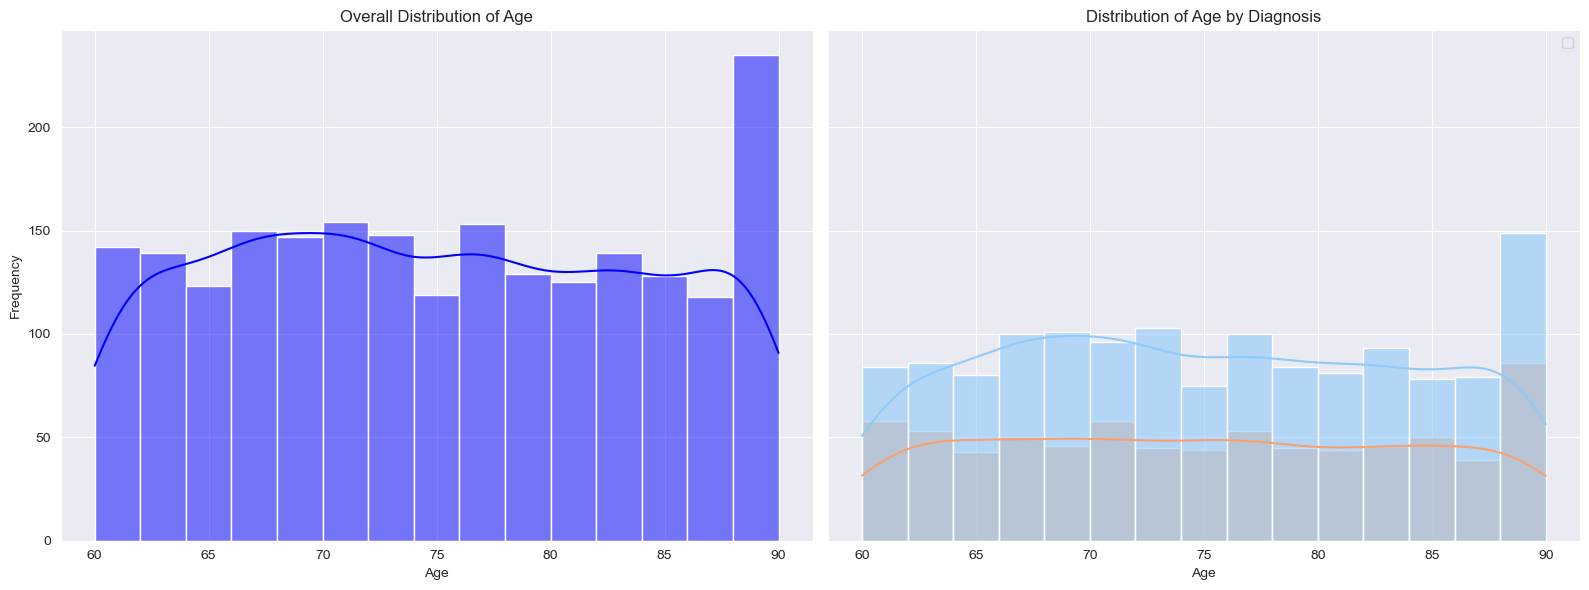

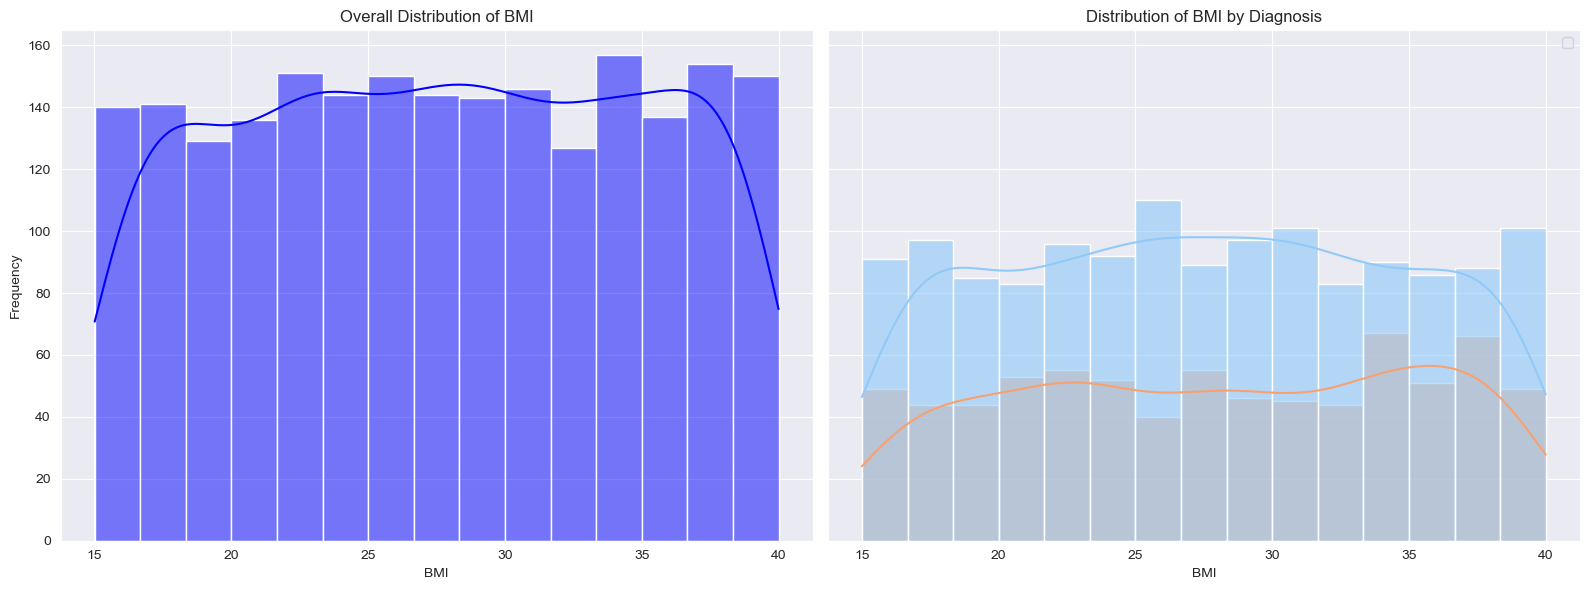

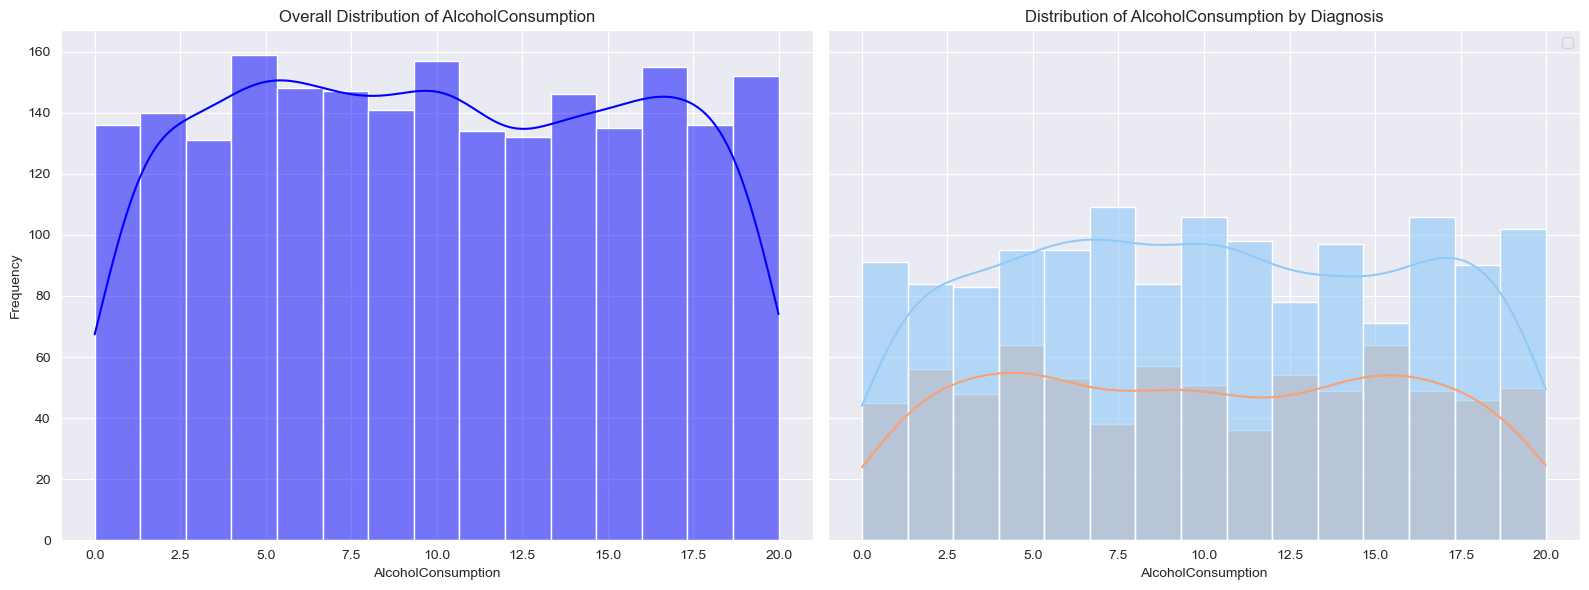

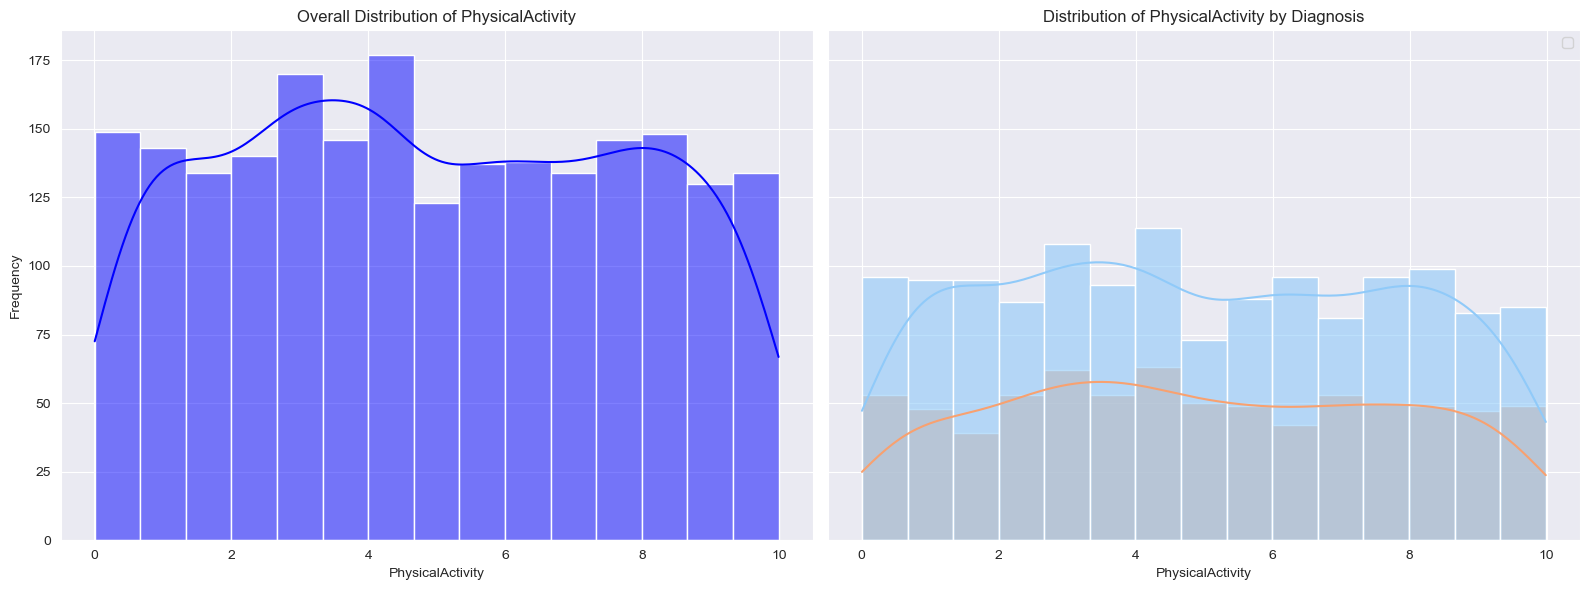

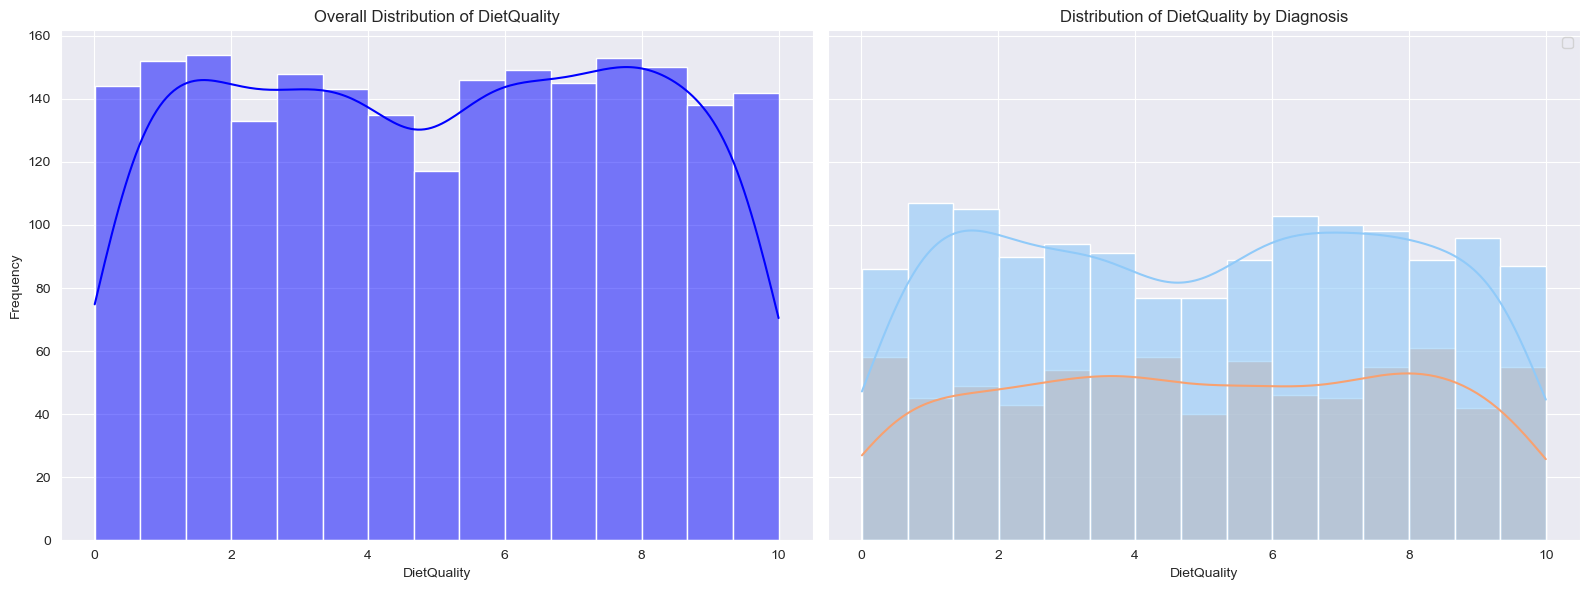

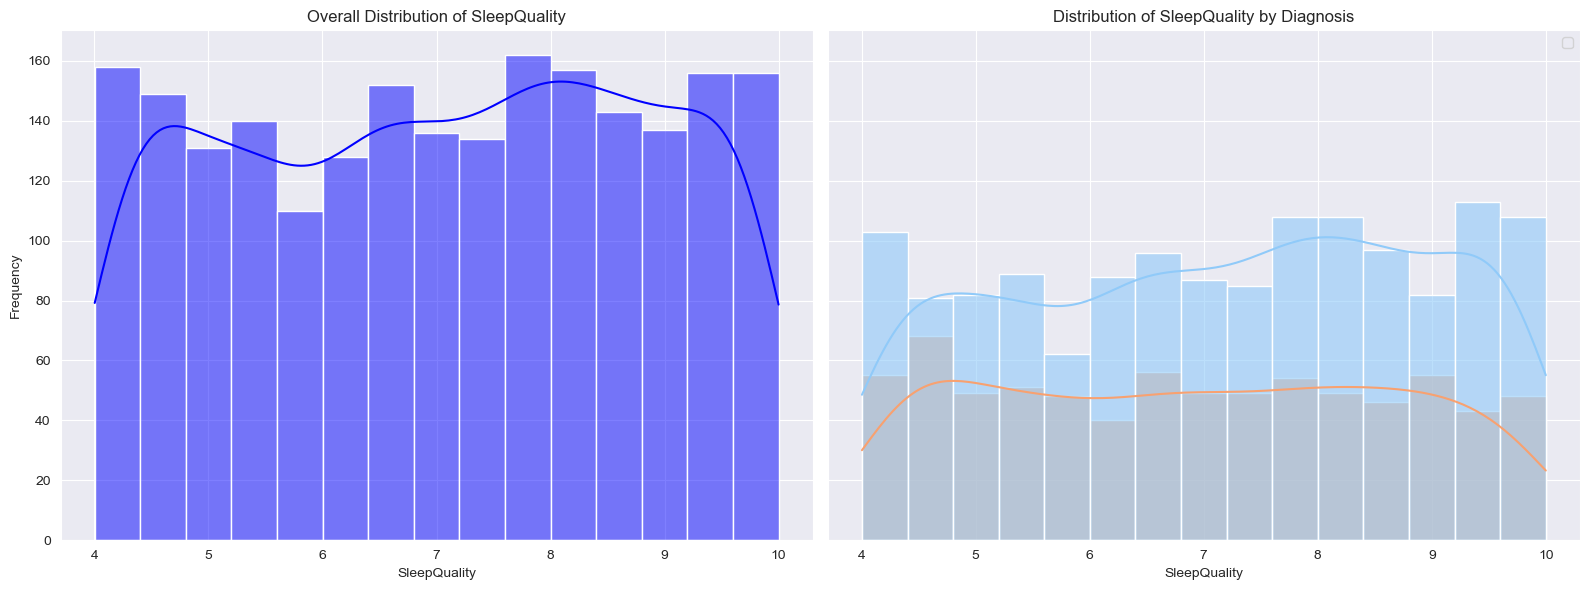

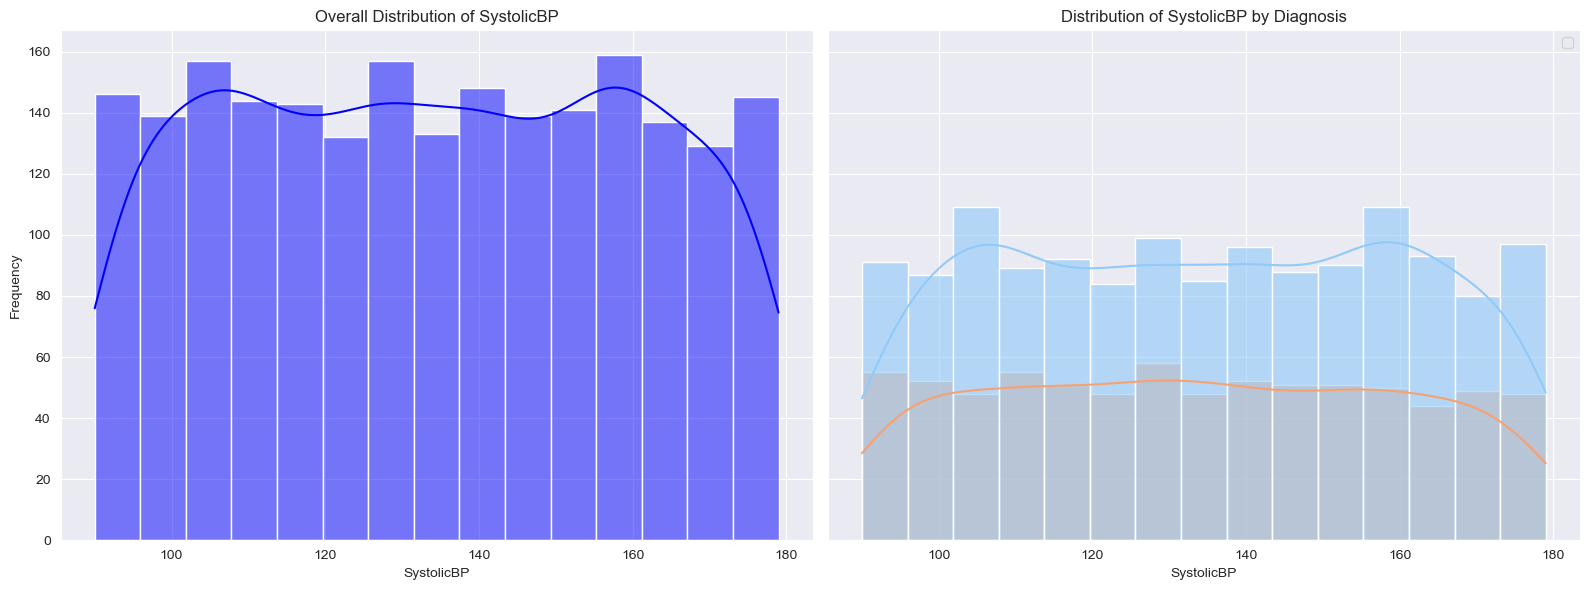

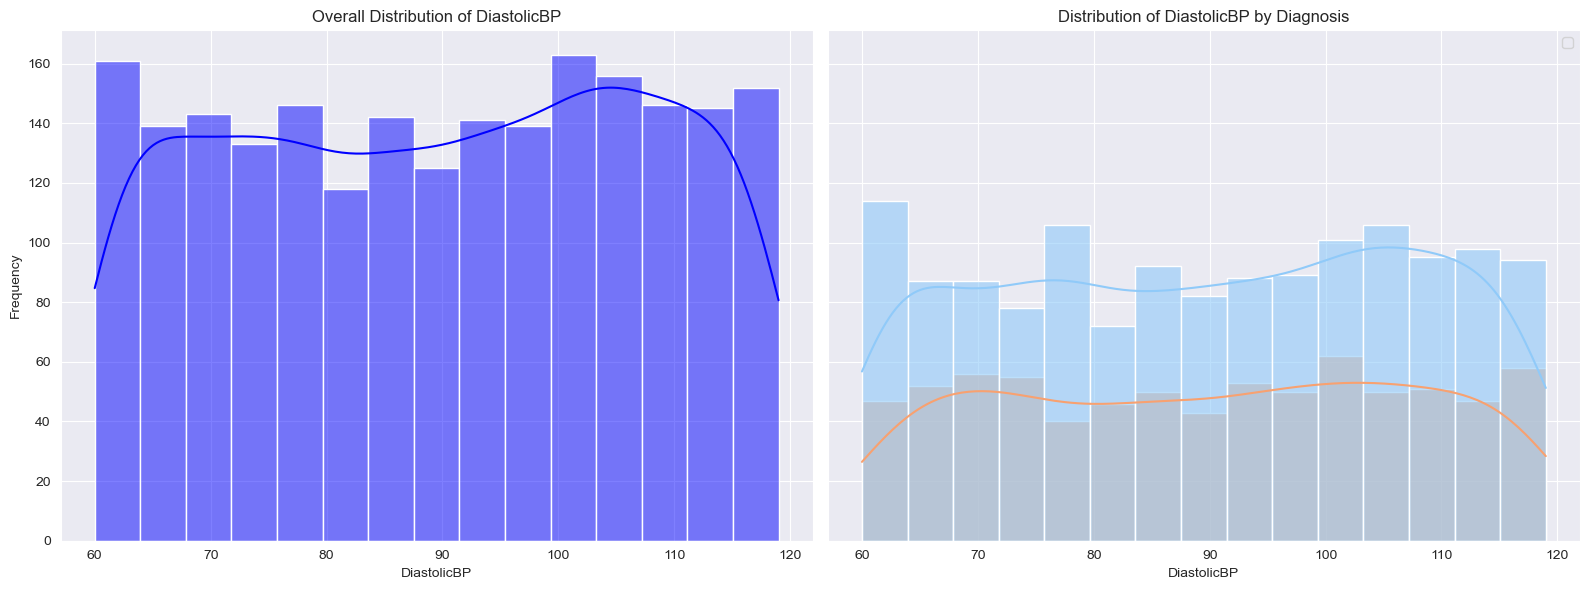

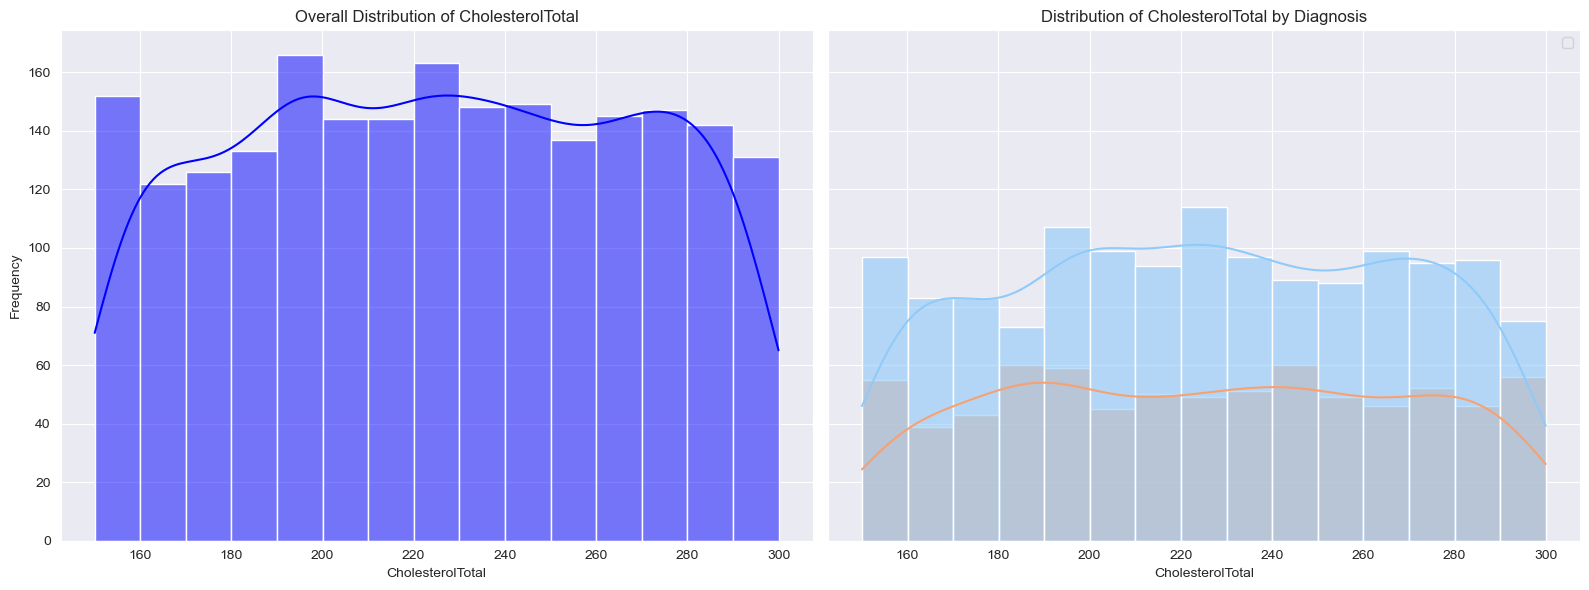

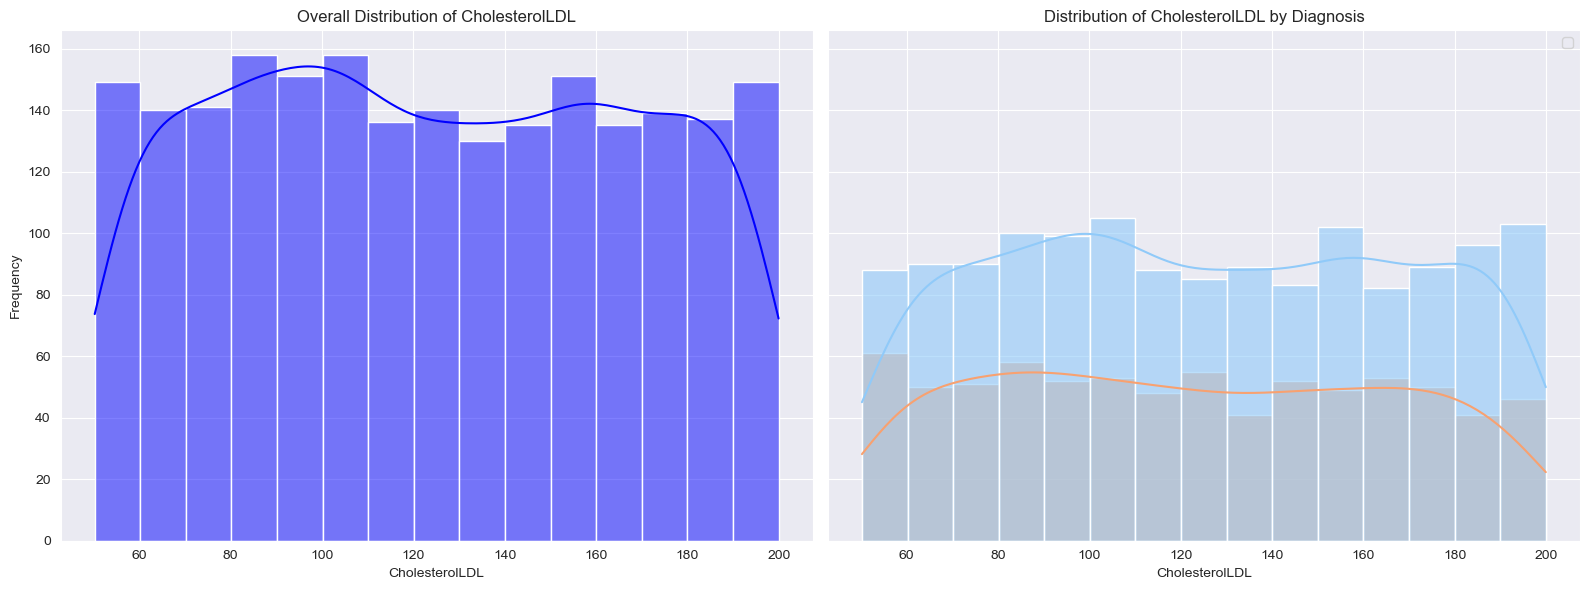

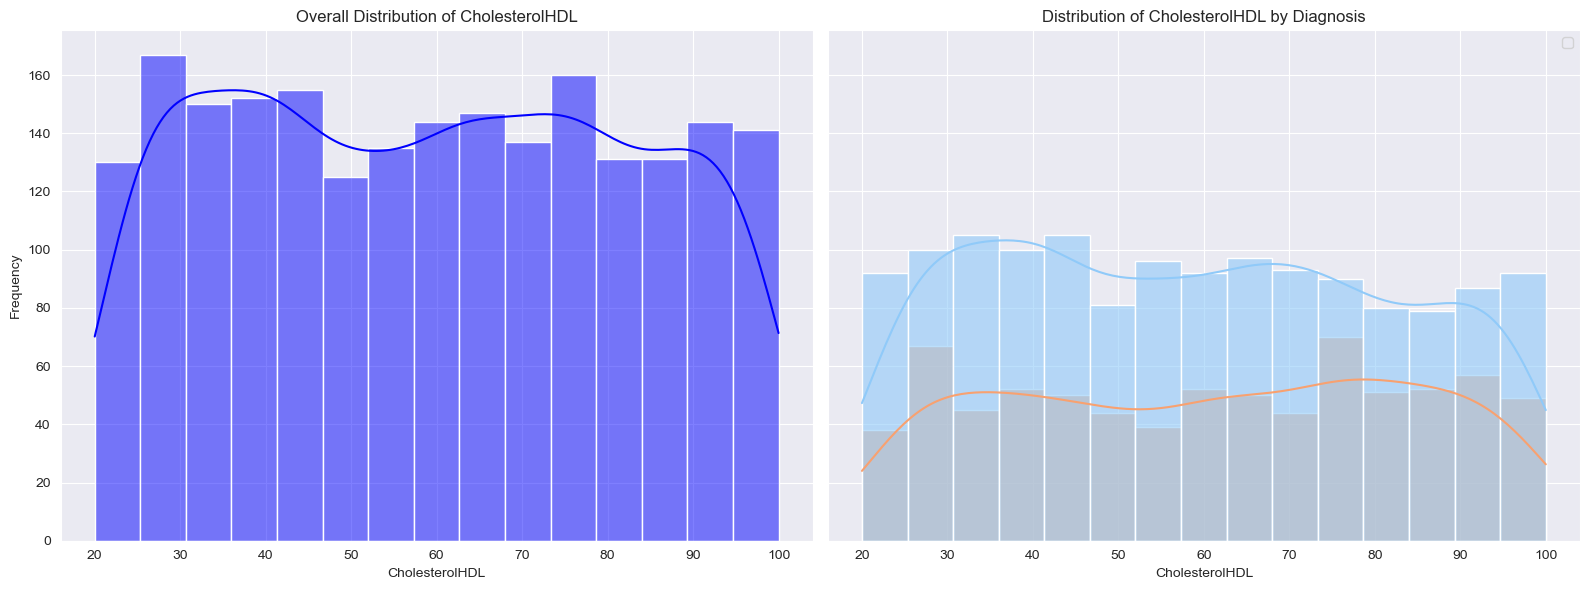

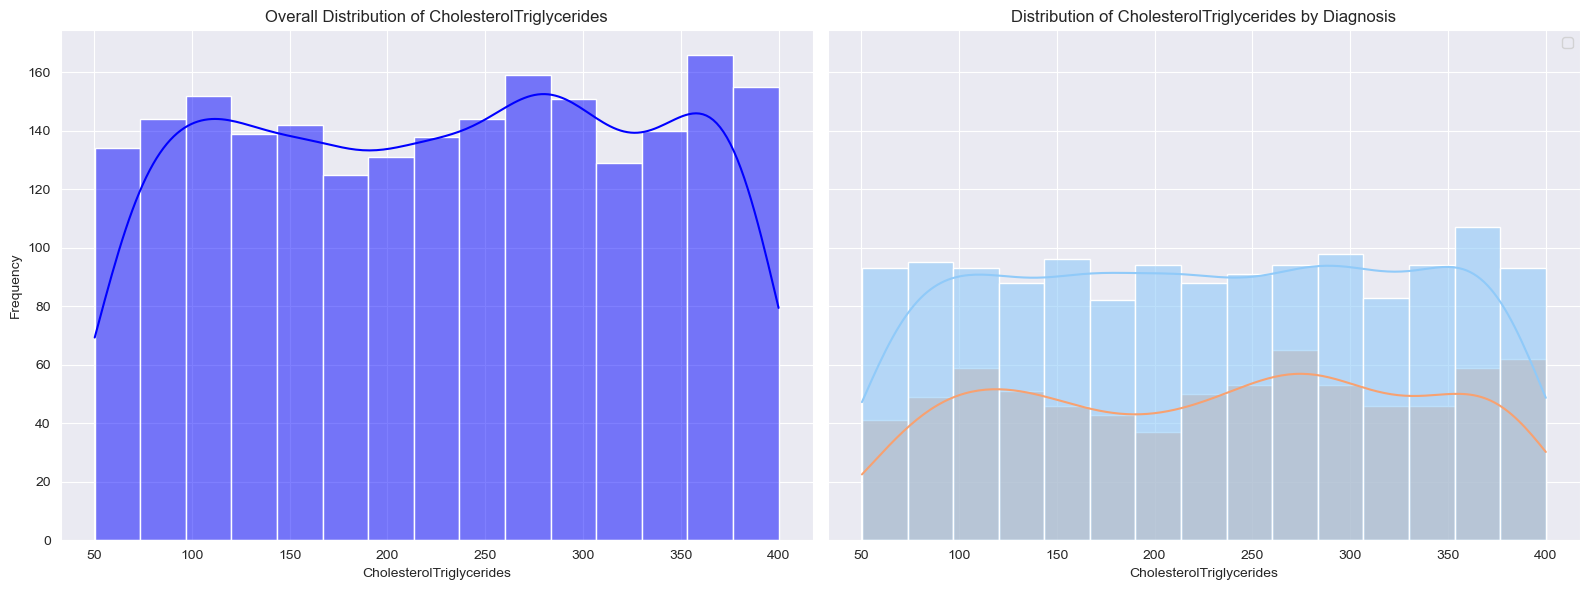

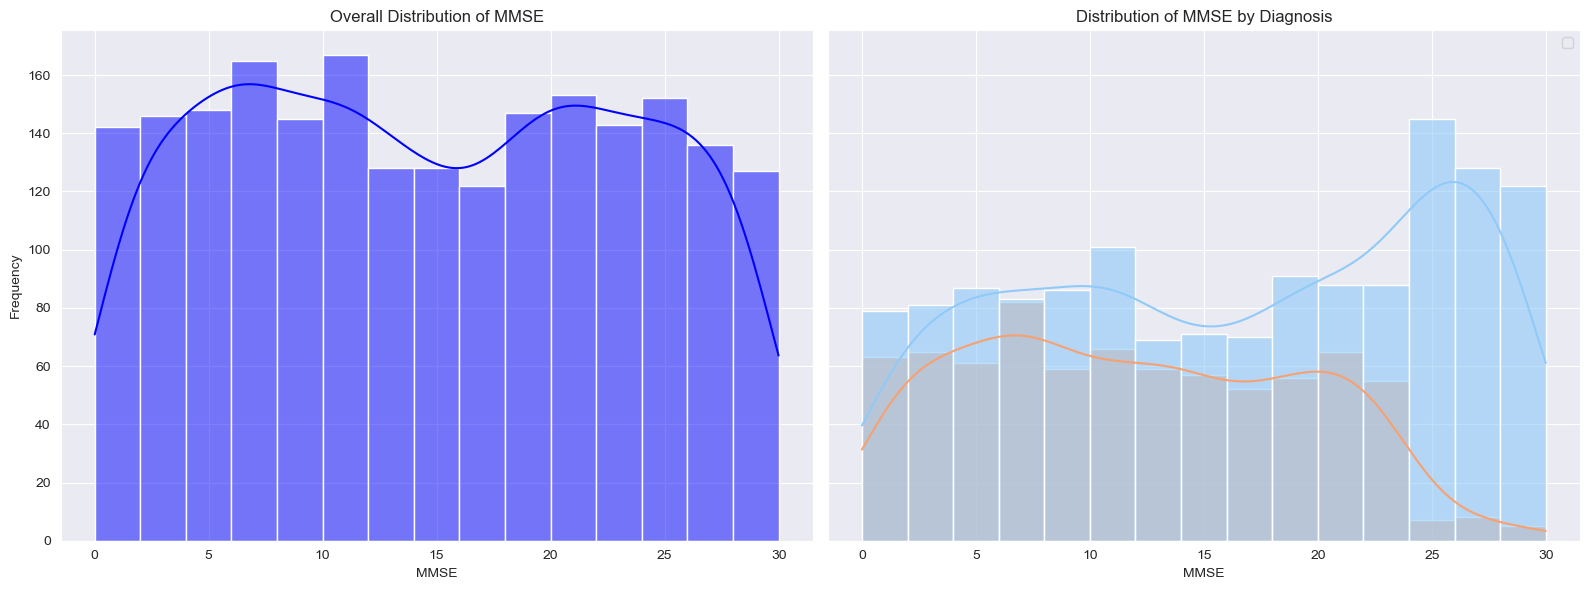

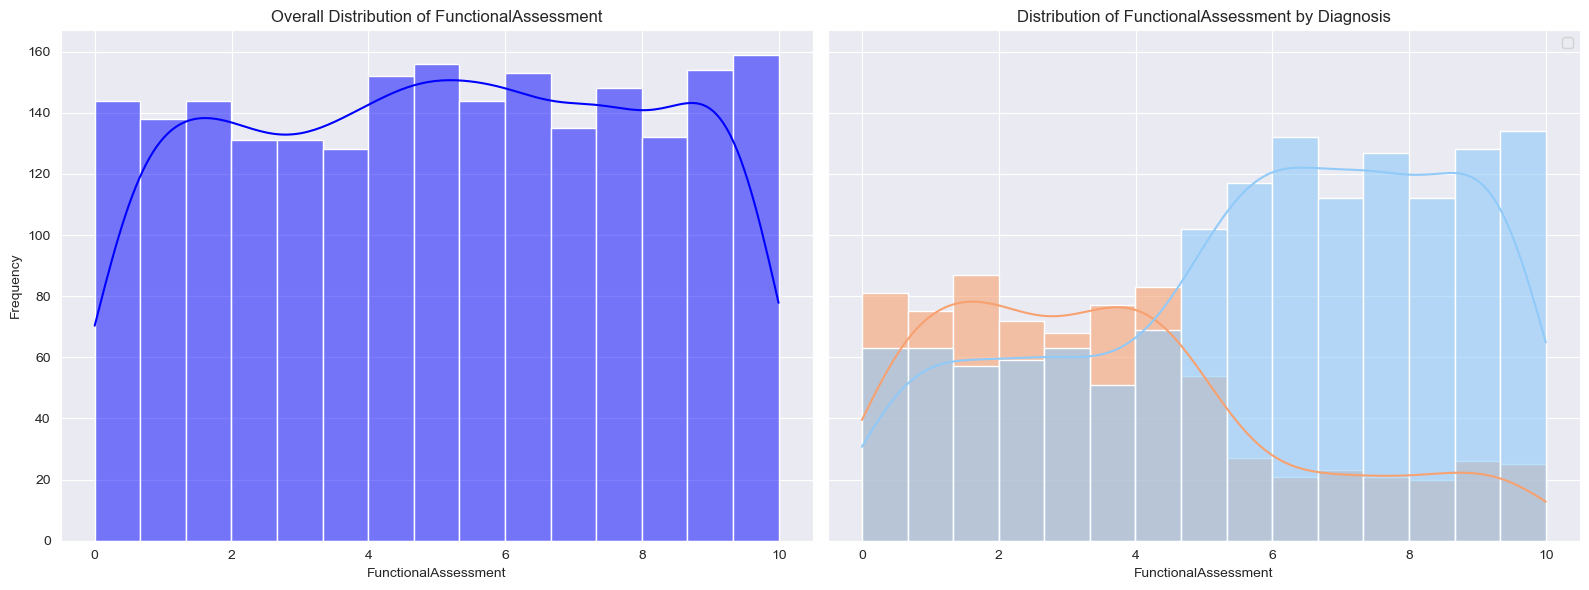

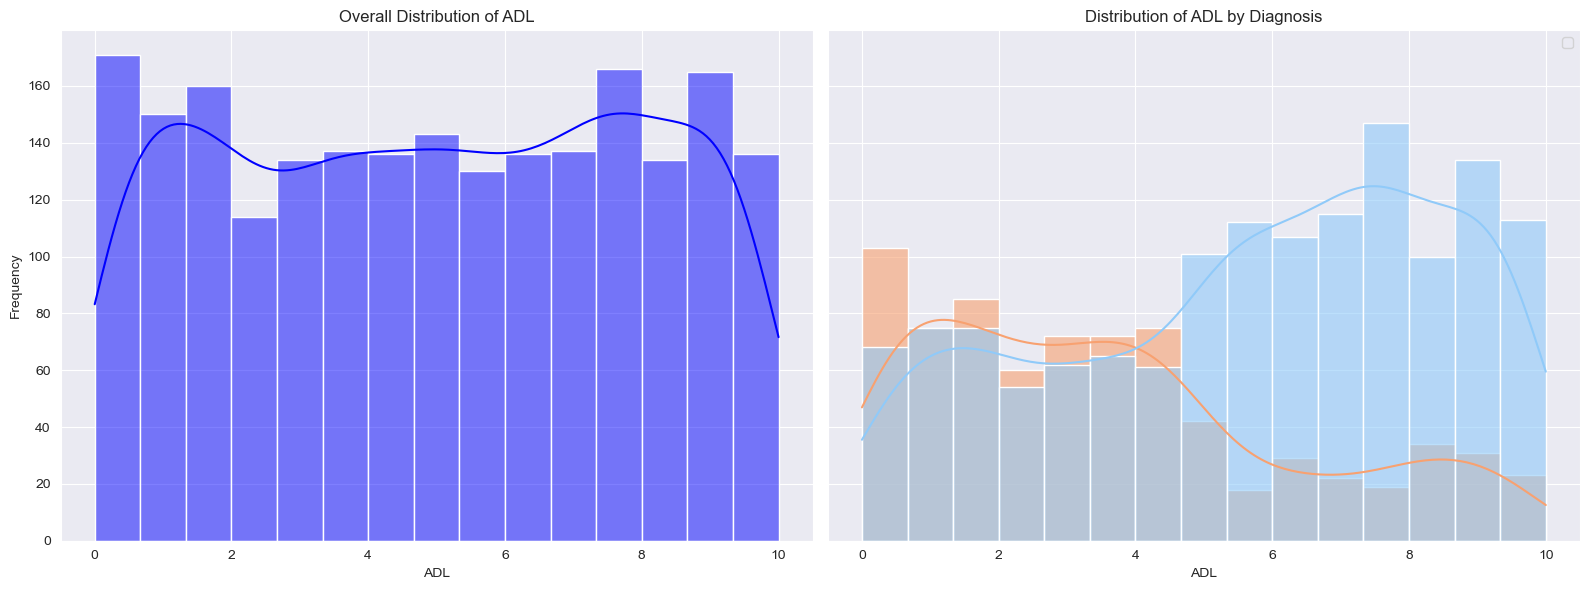

In [35]:
plot_histograms_separate(dataset, numerical_columns)

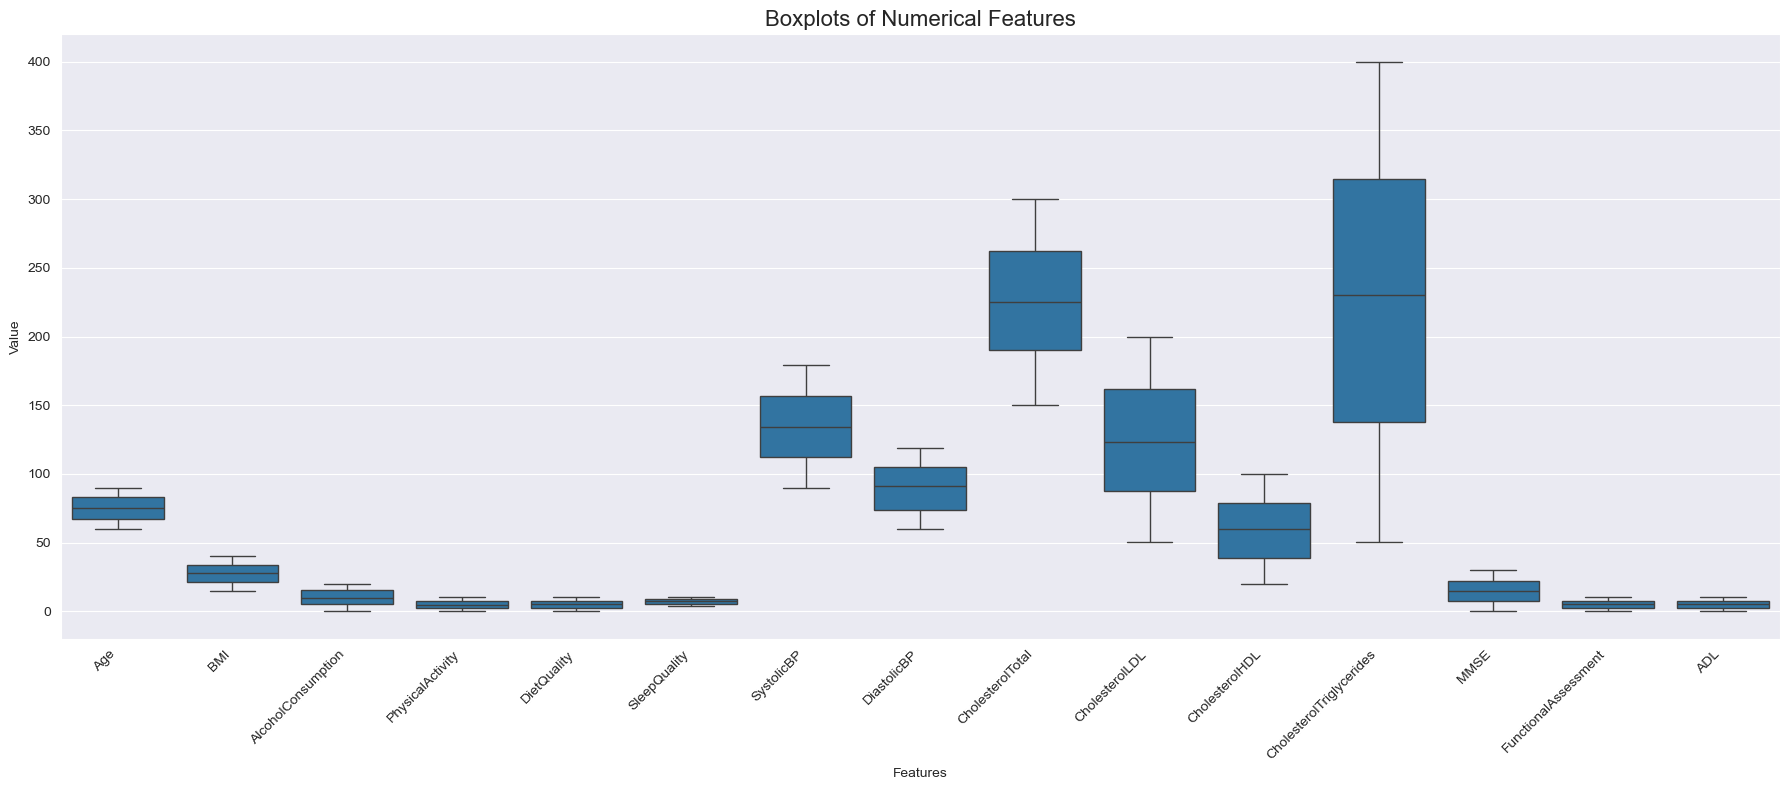

In [36]:
plot_boxplots(dataset)

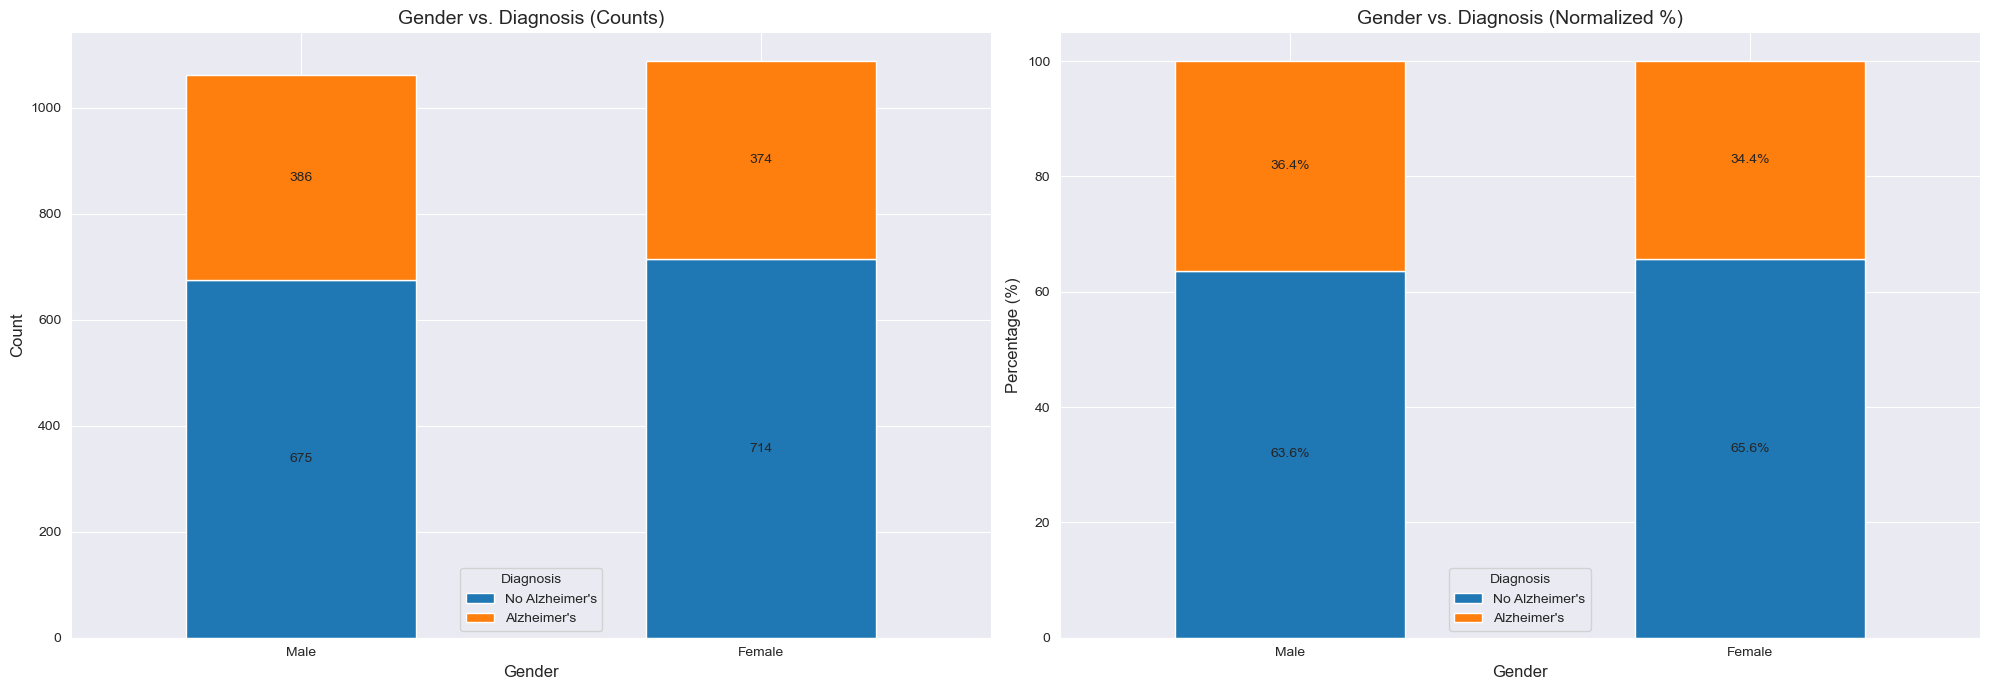

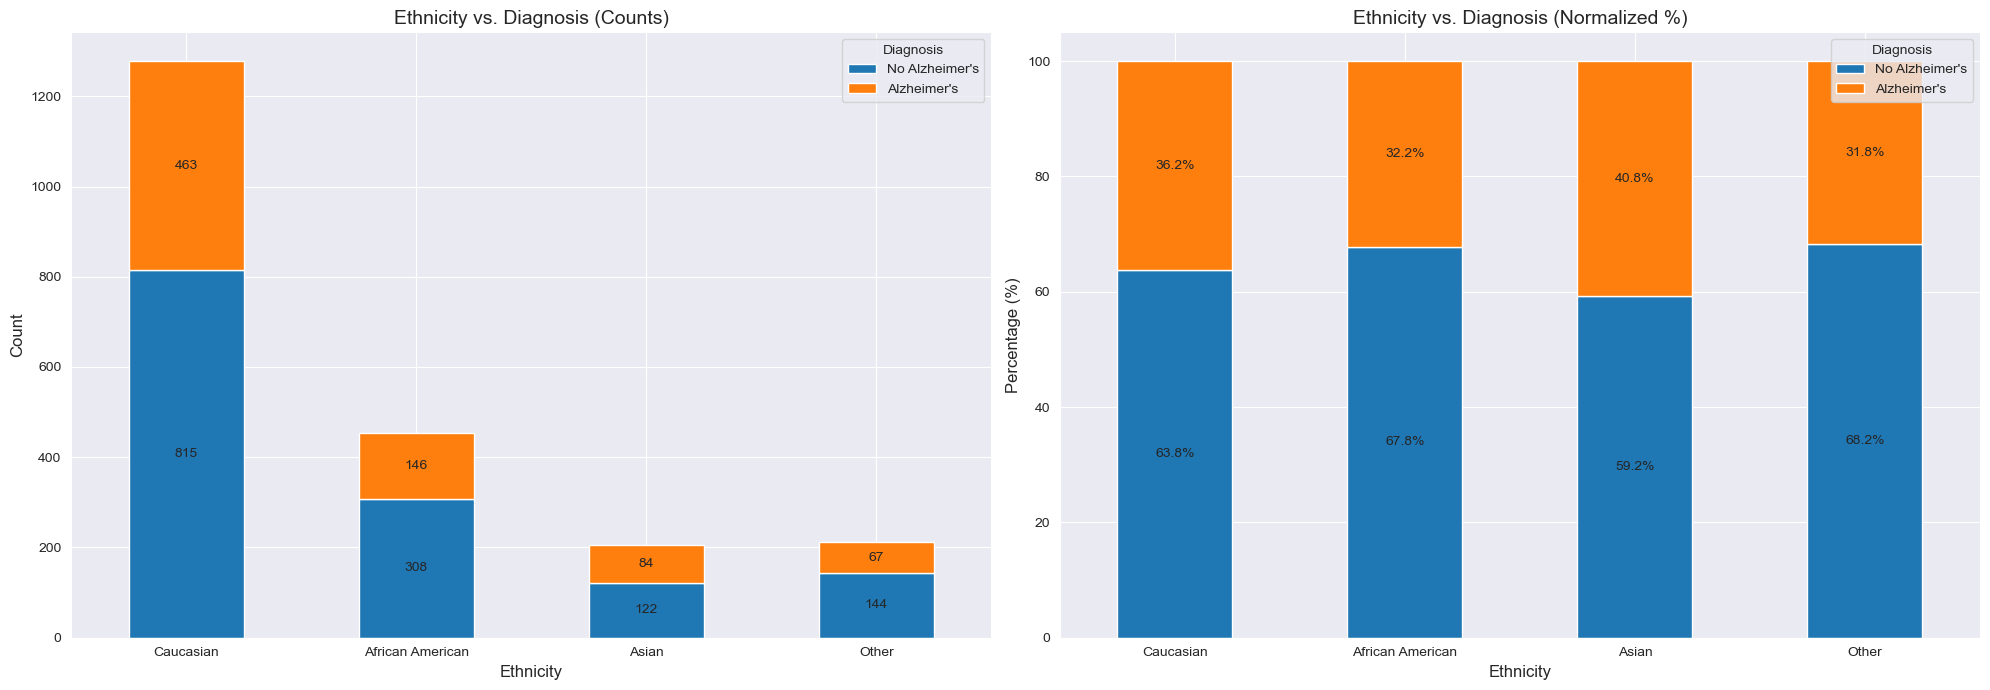

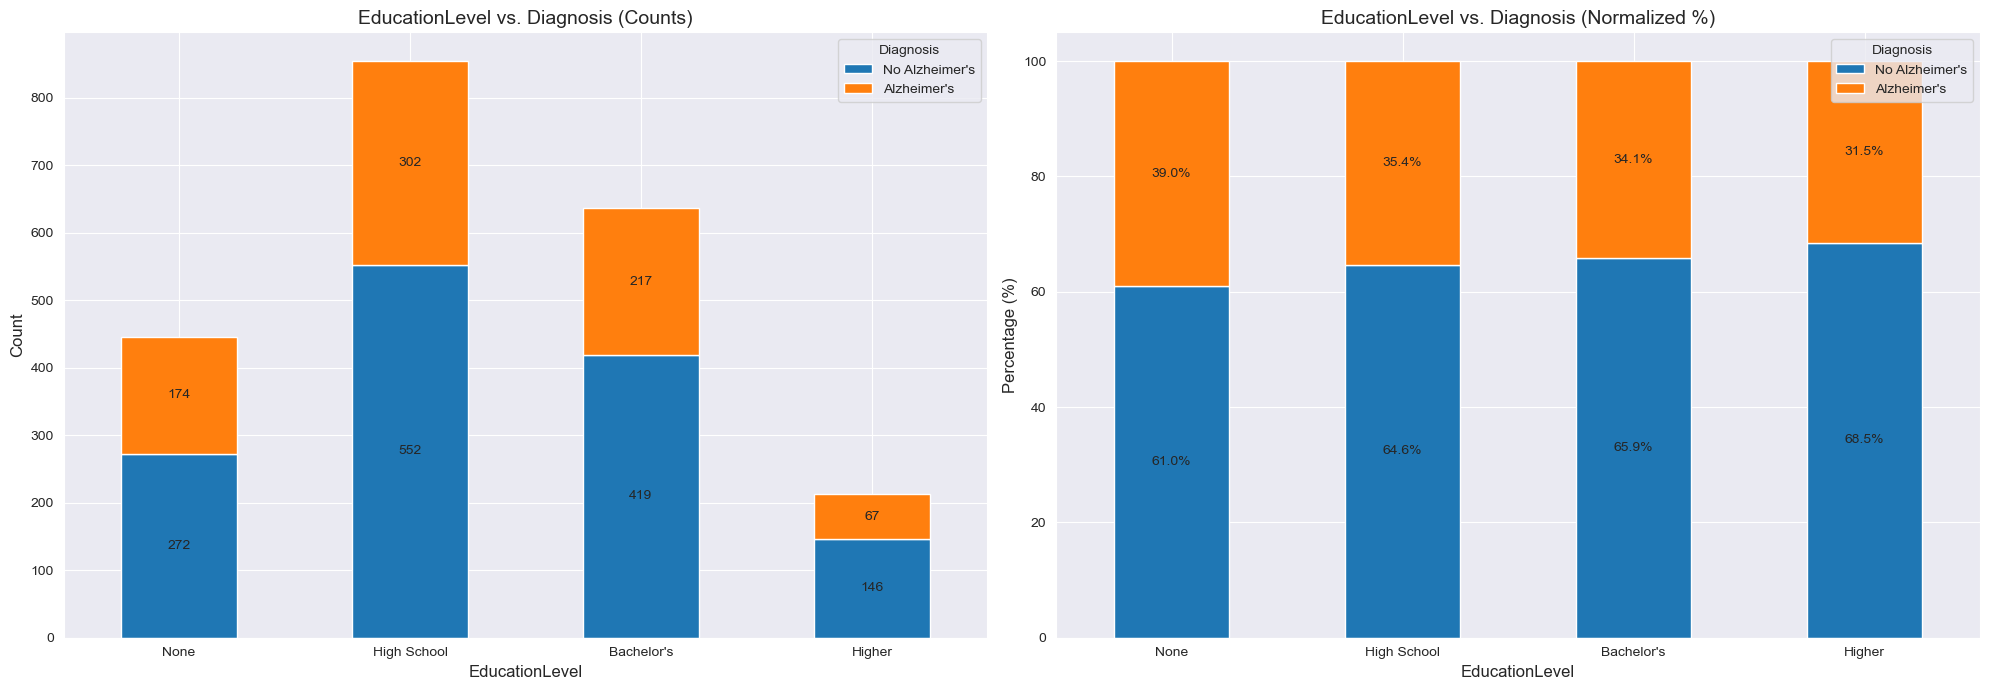

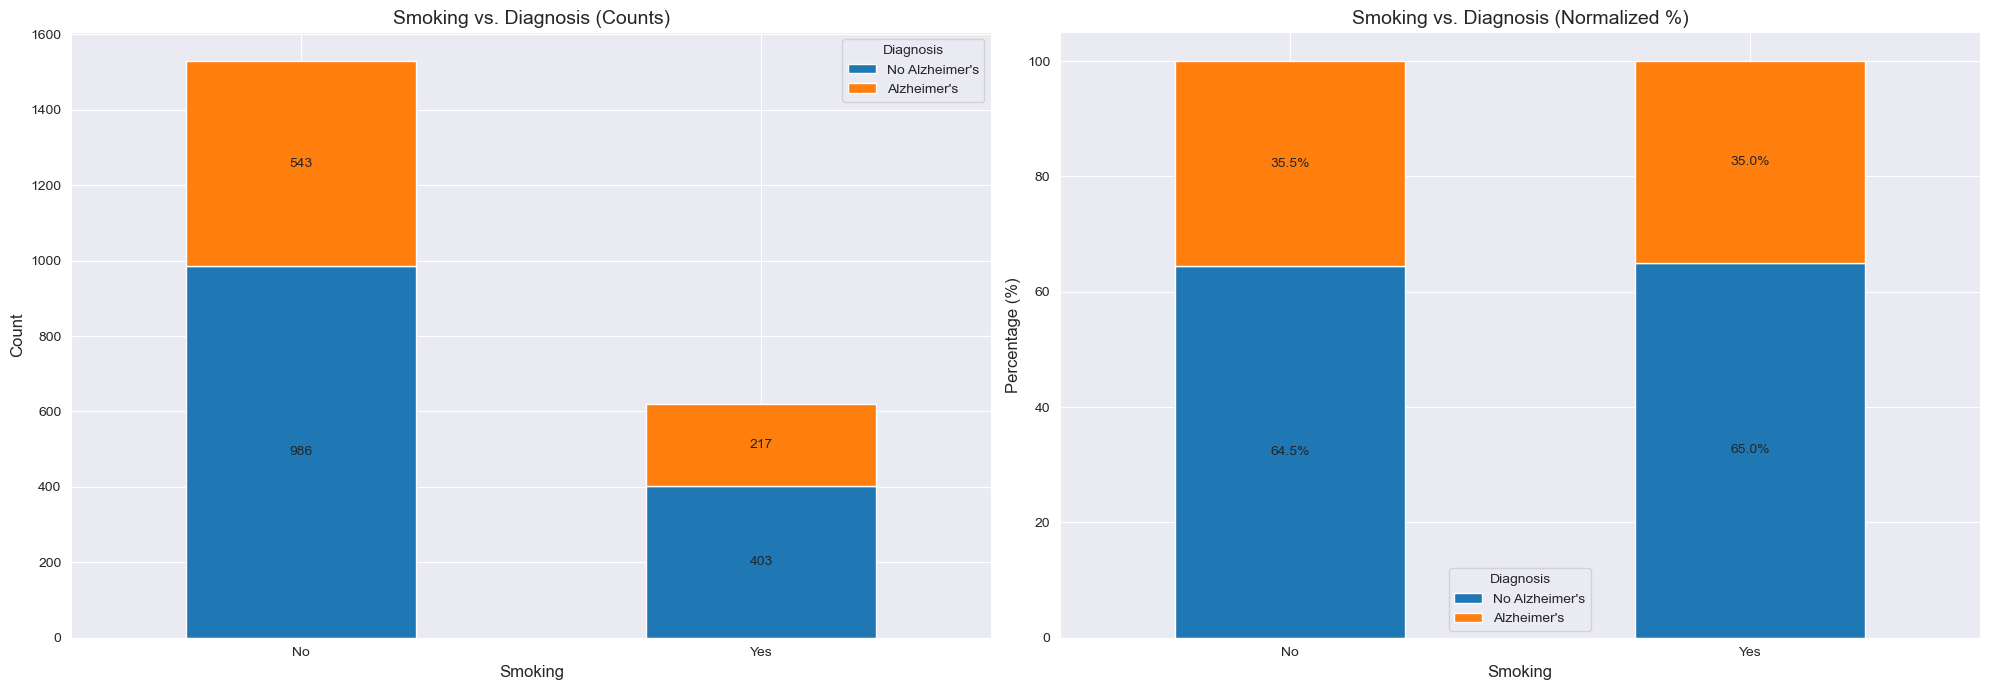

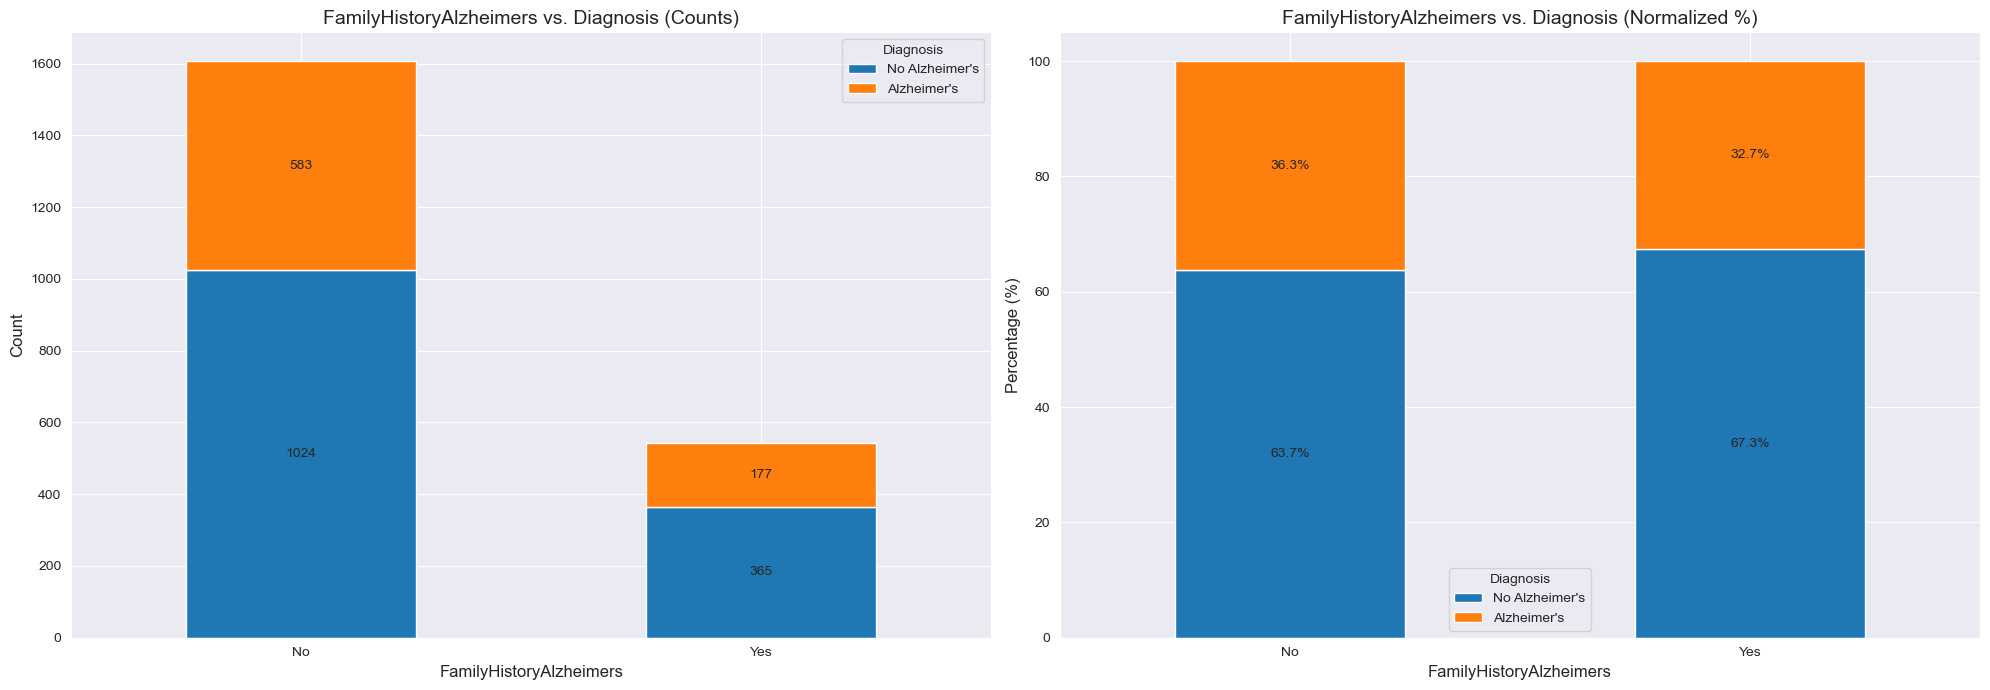

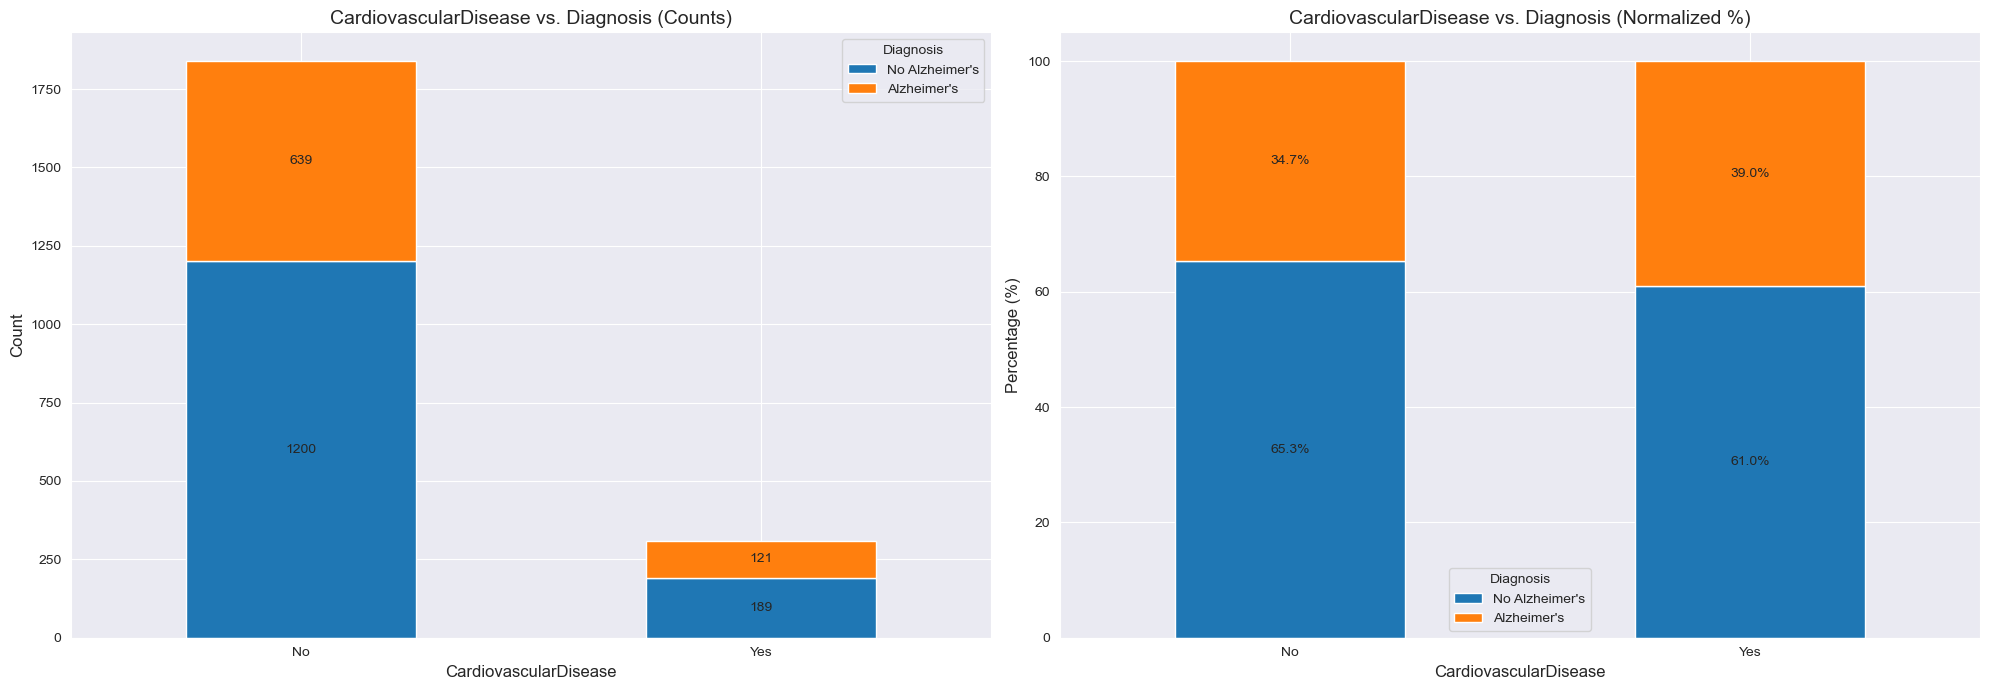

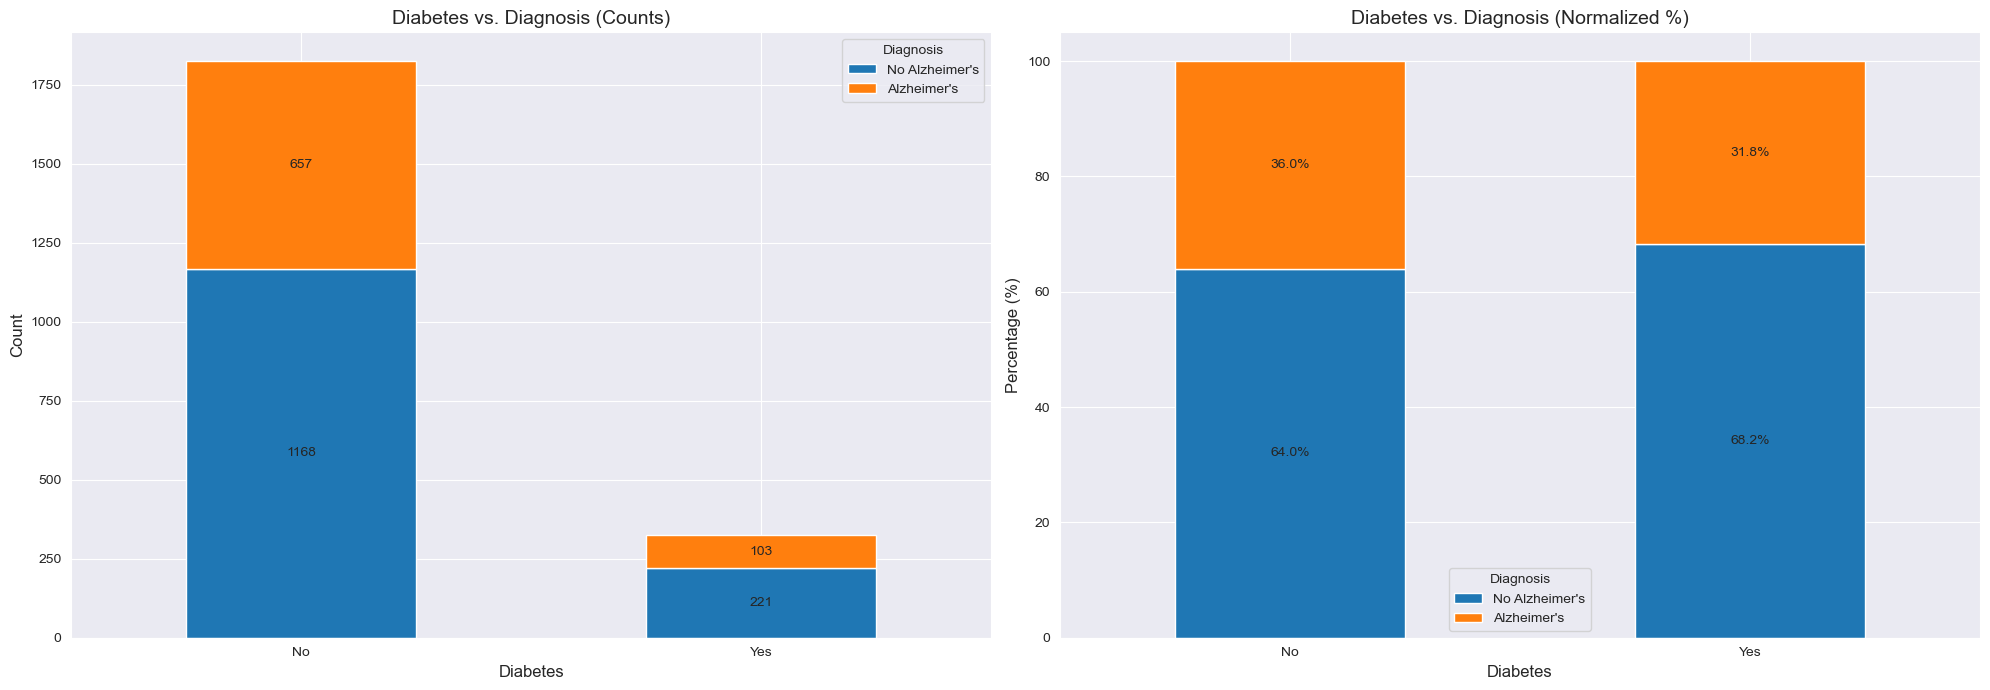

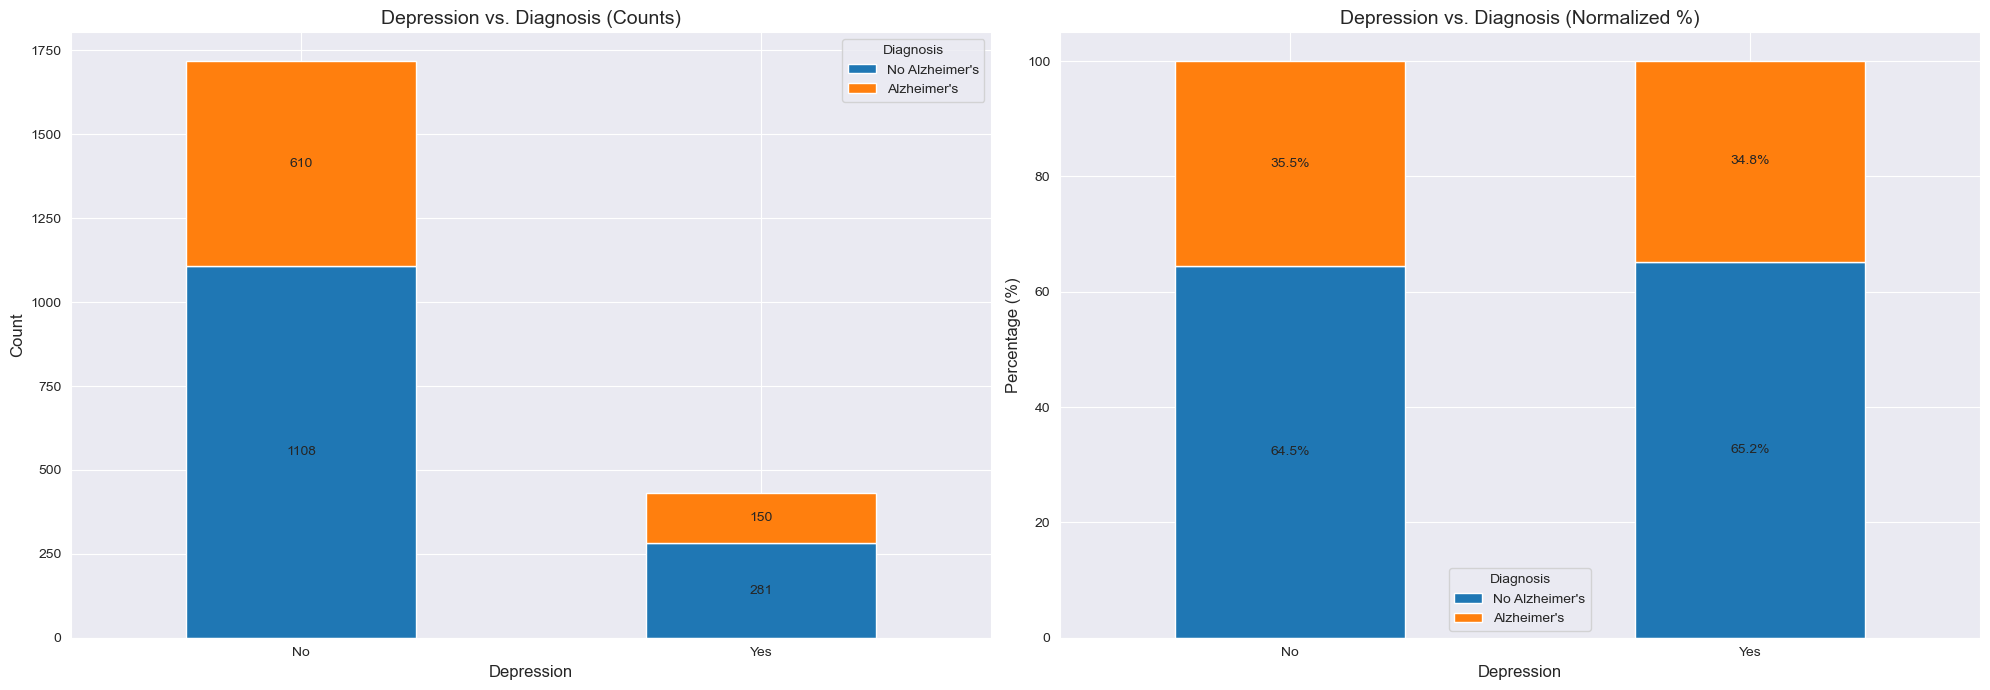

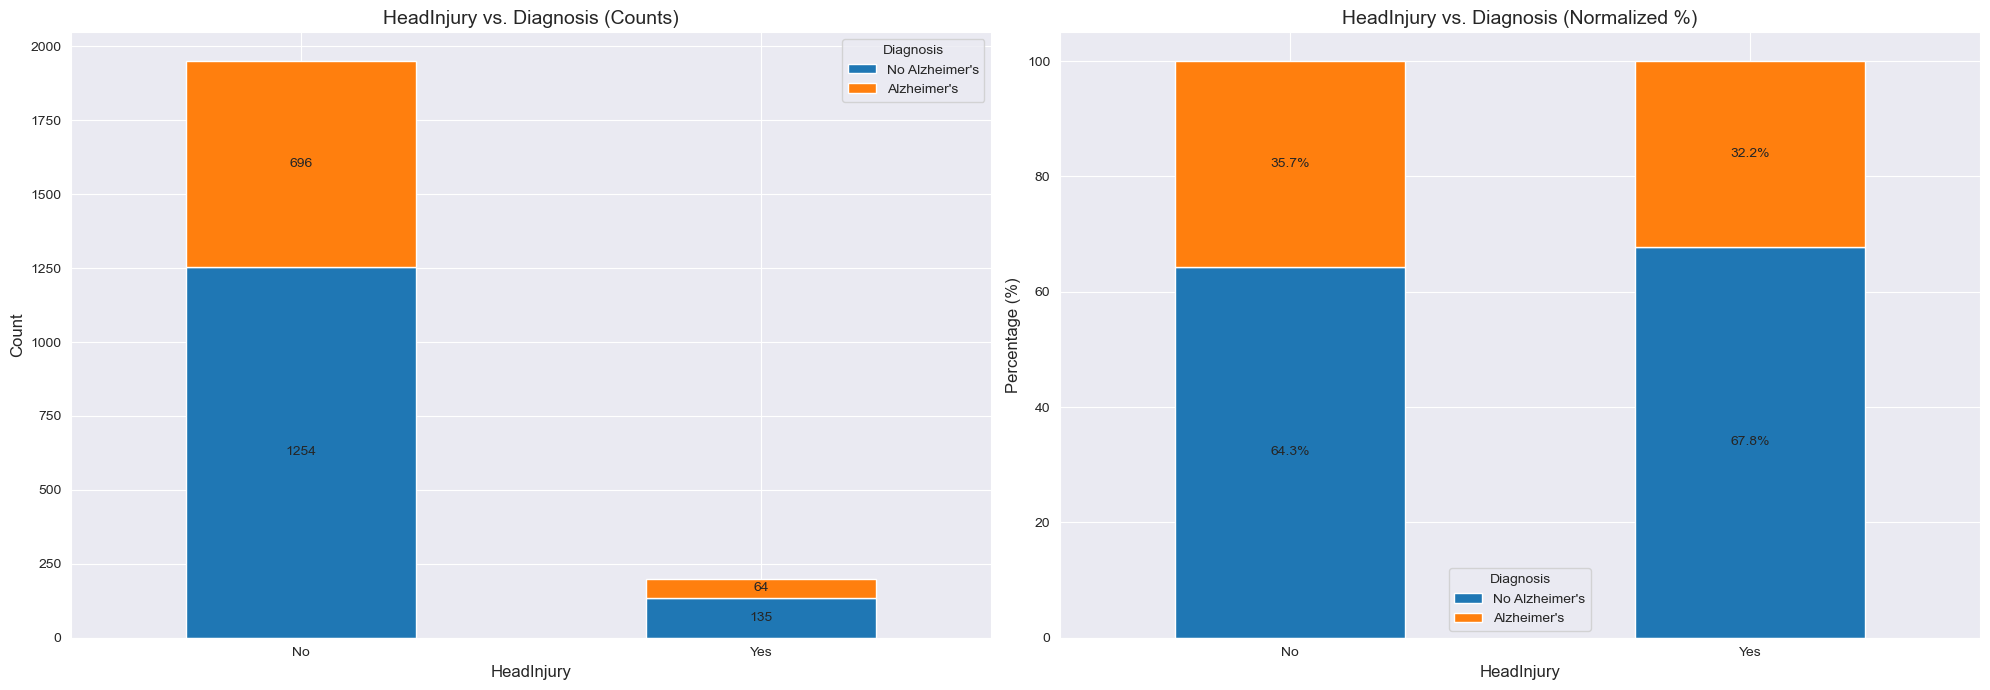

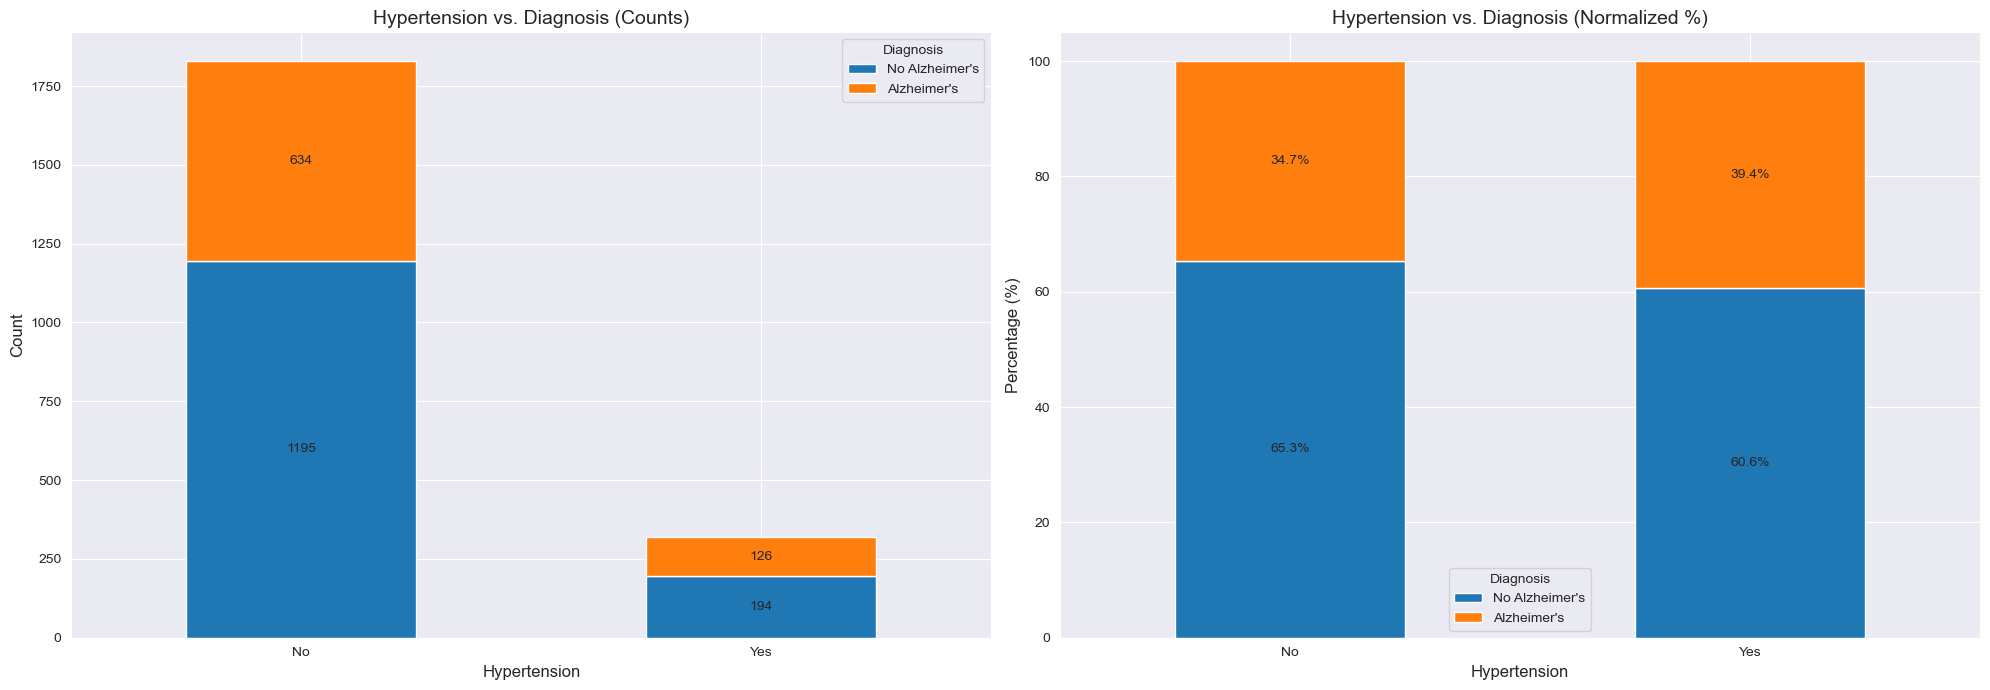

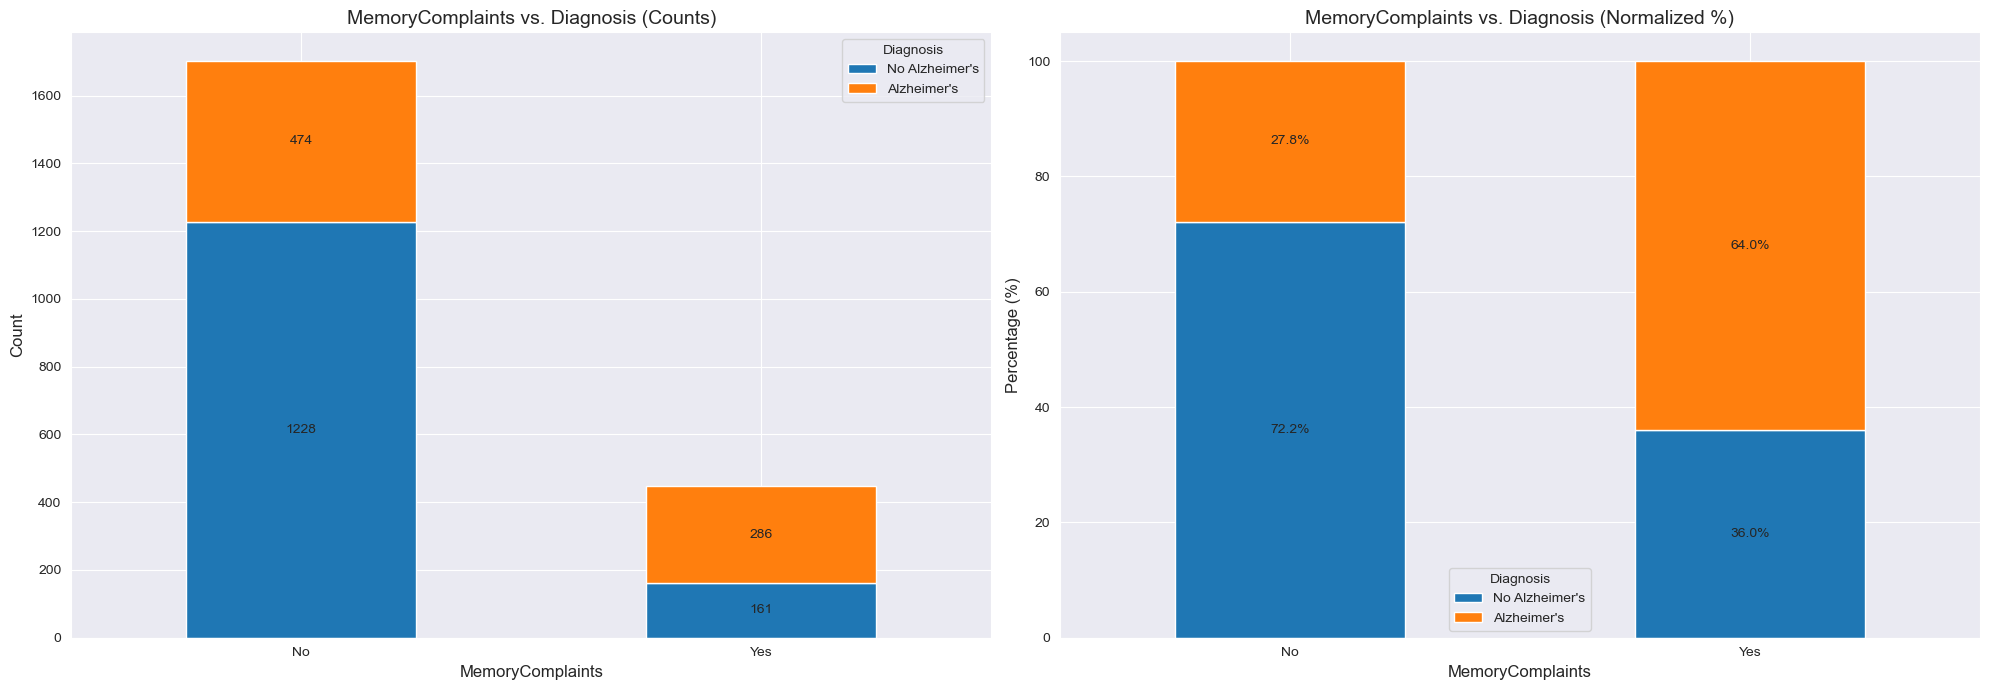

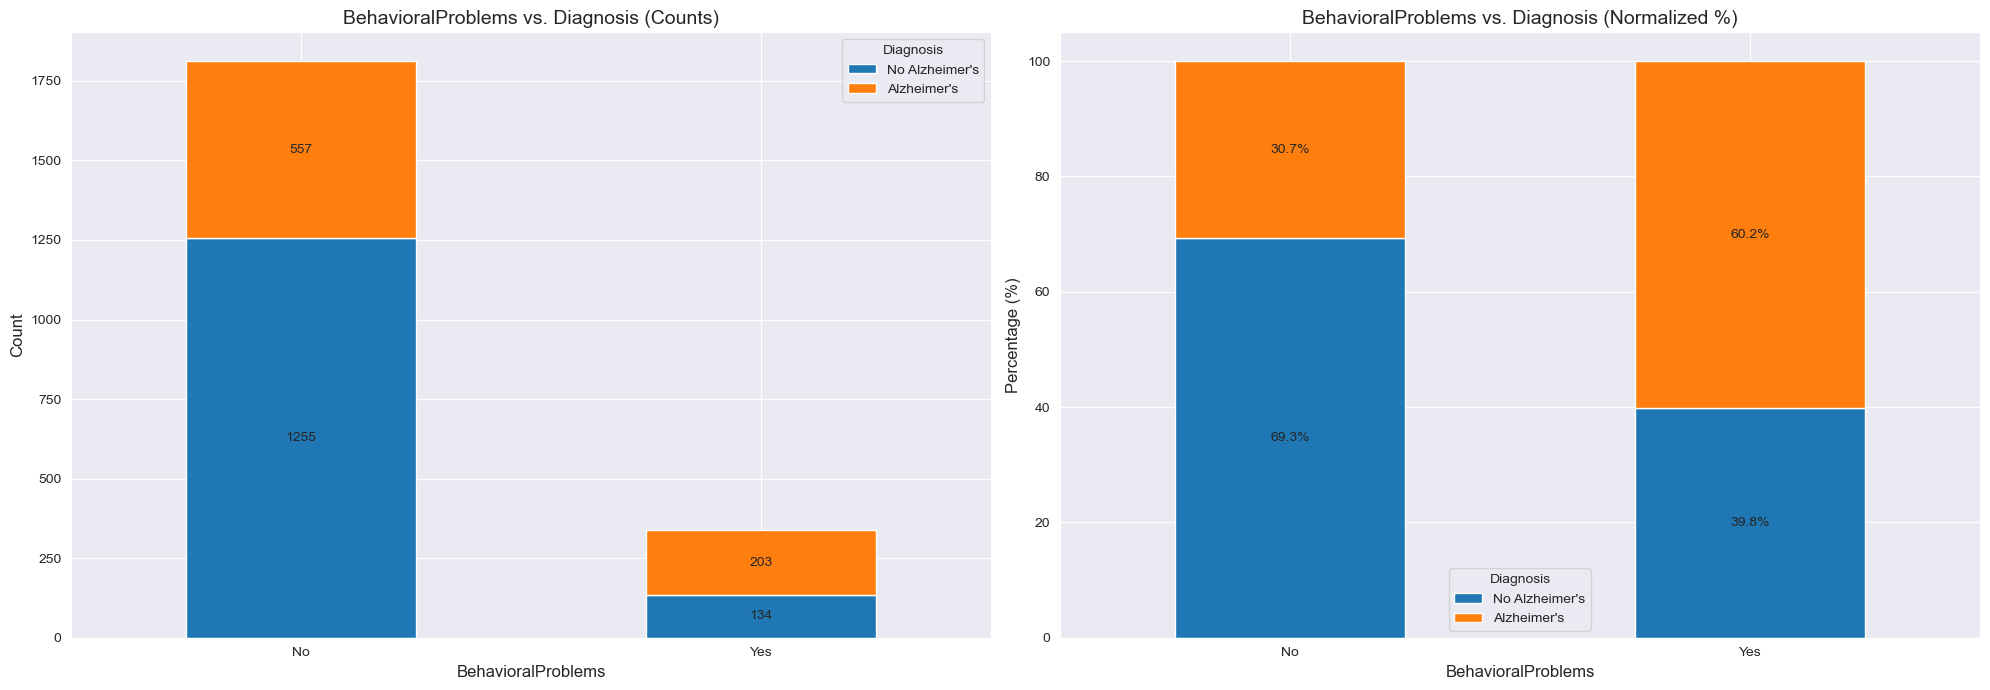

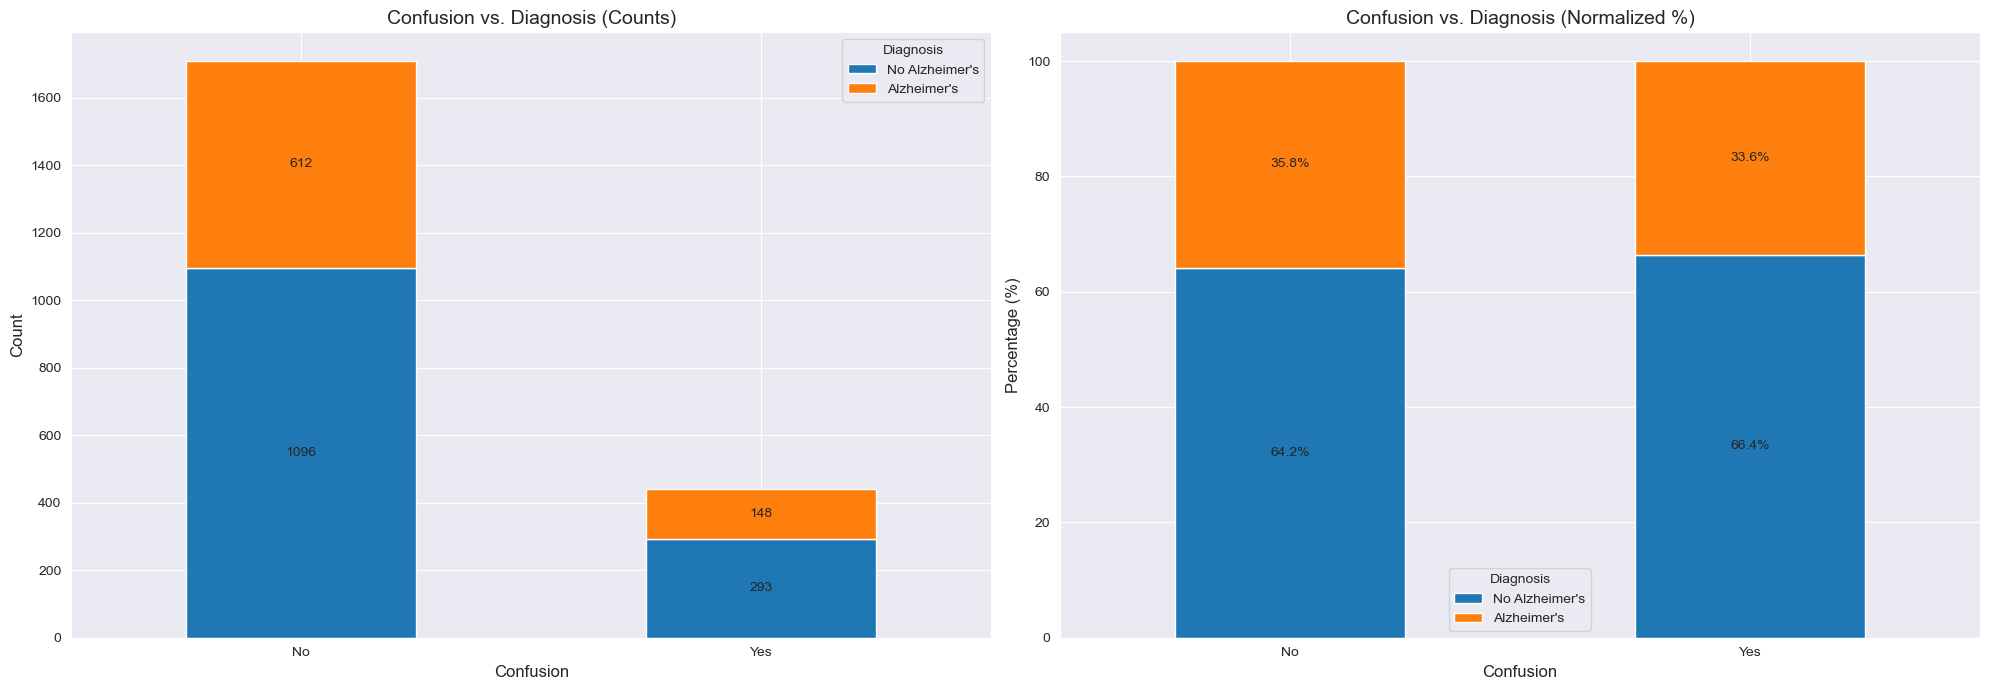

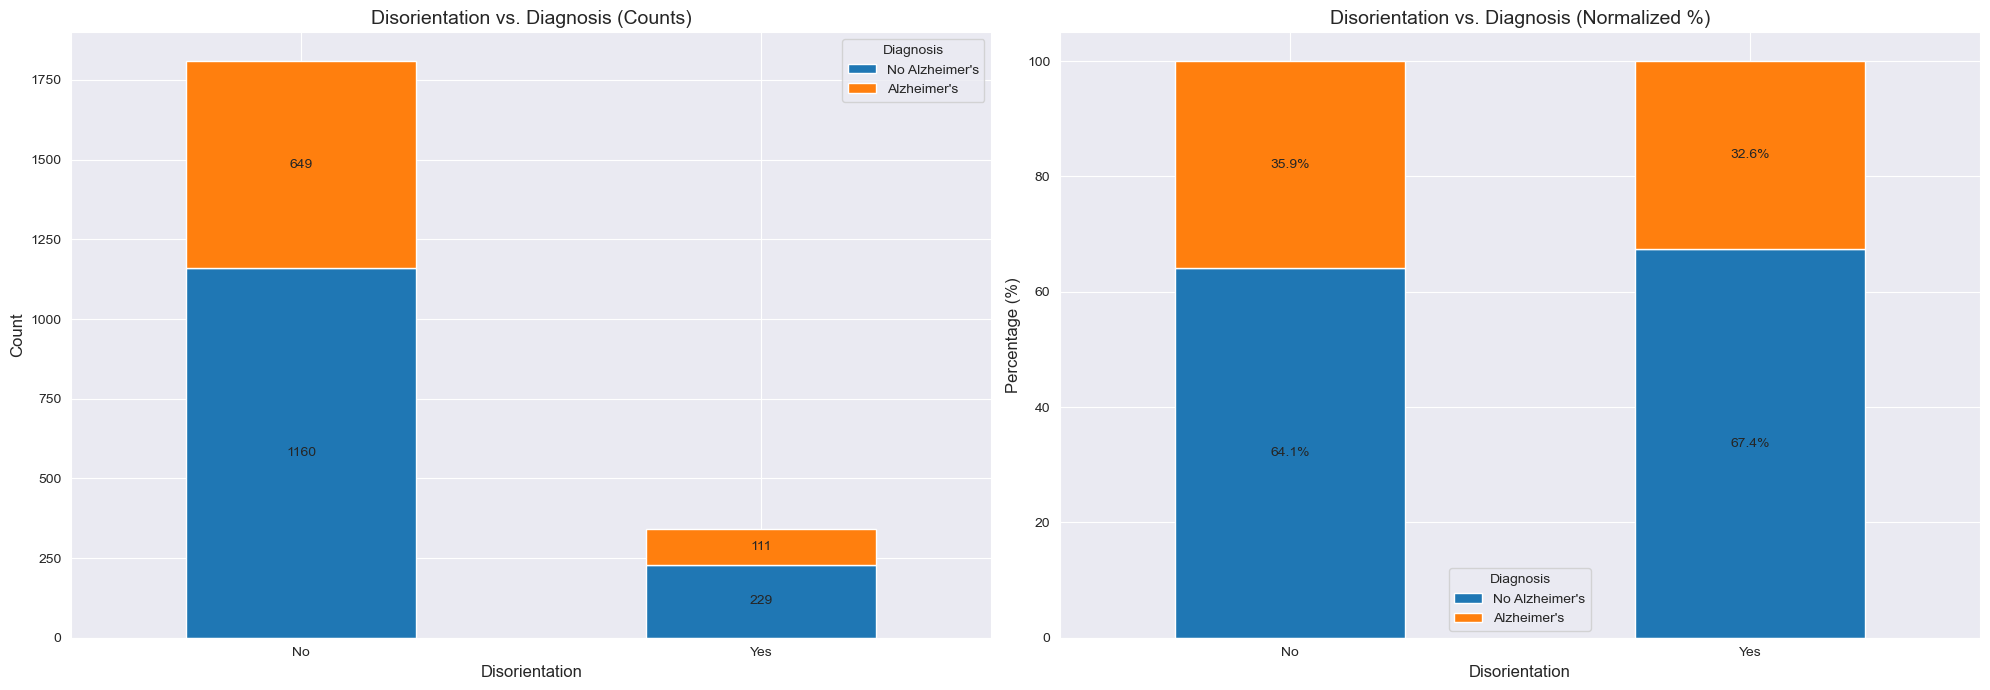

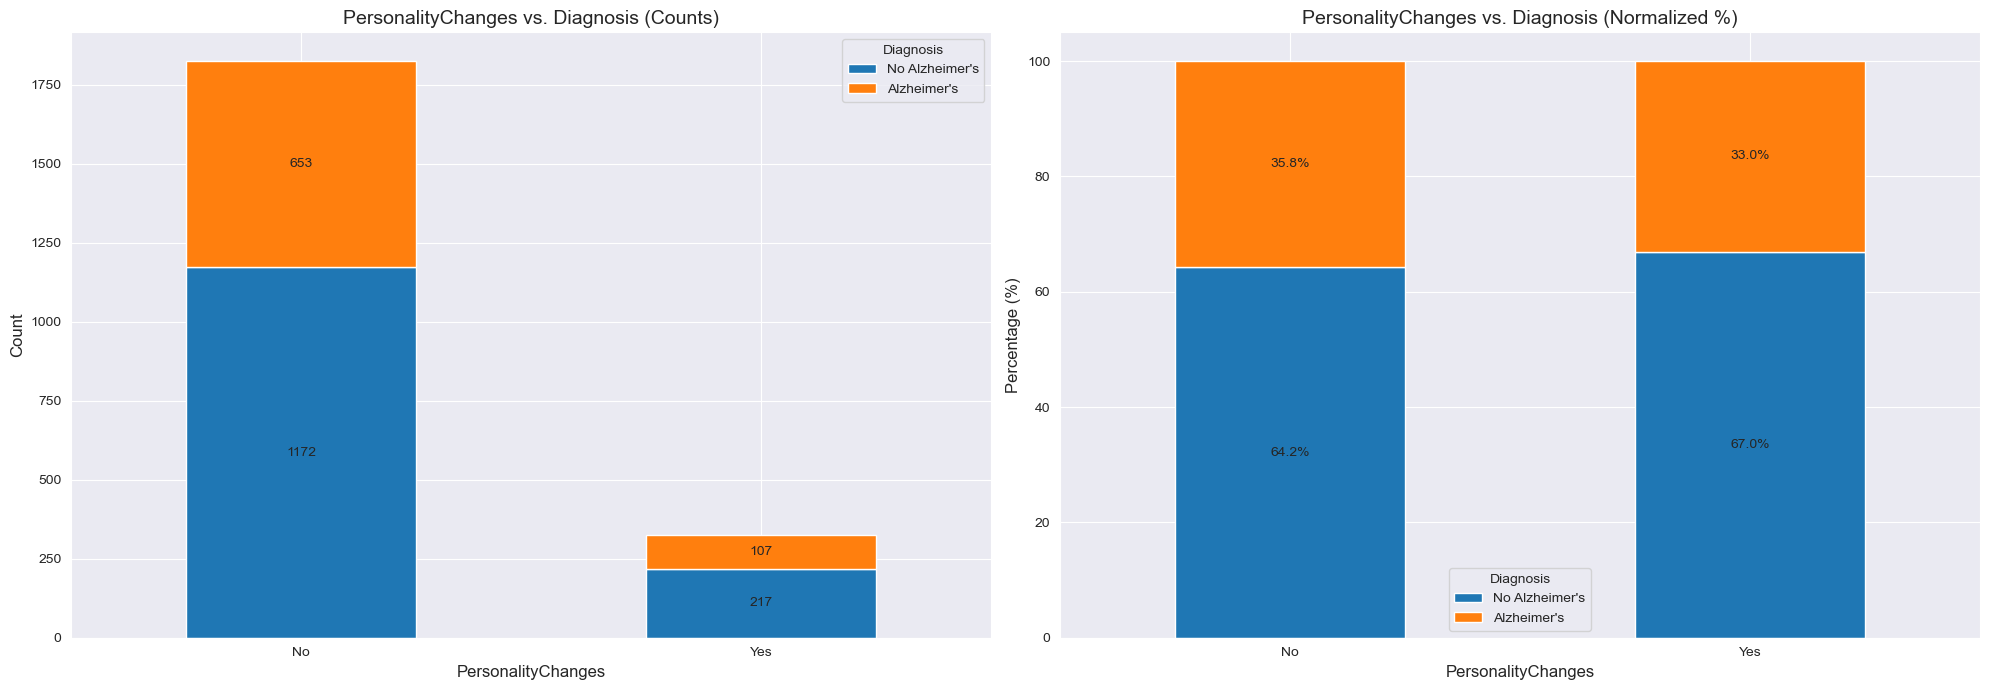

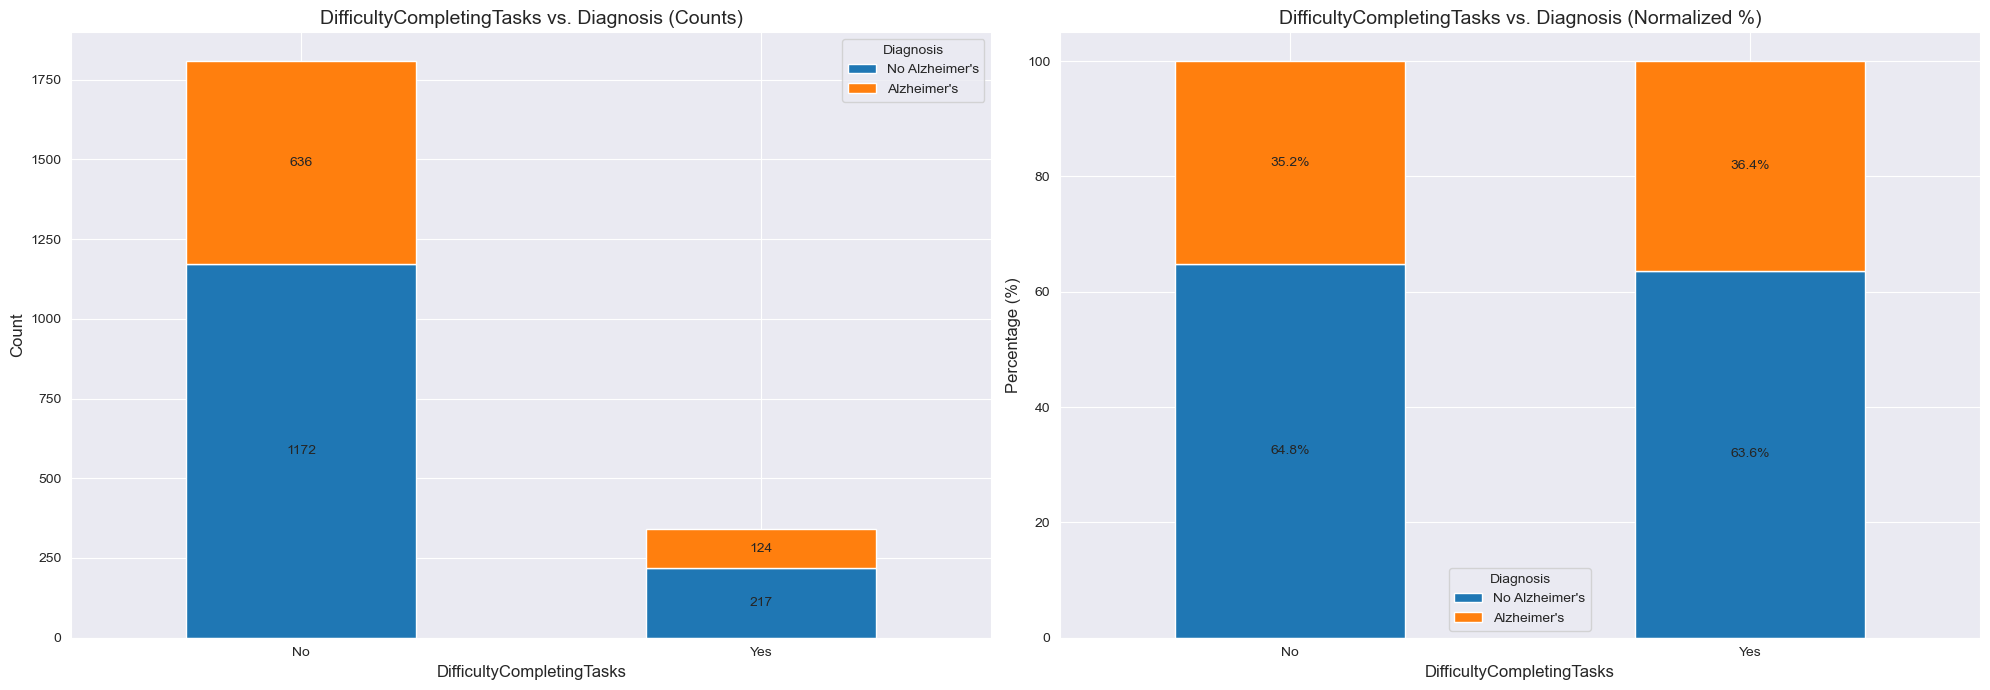

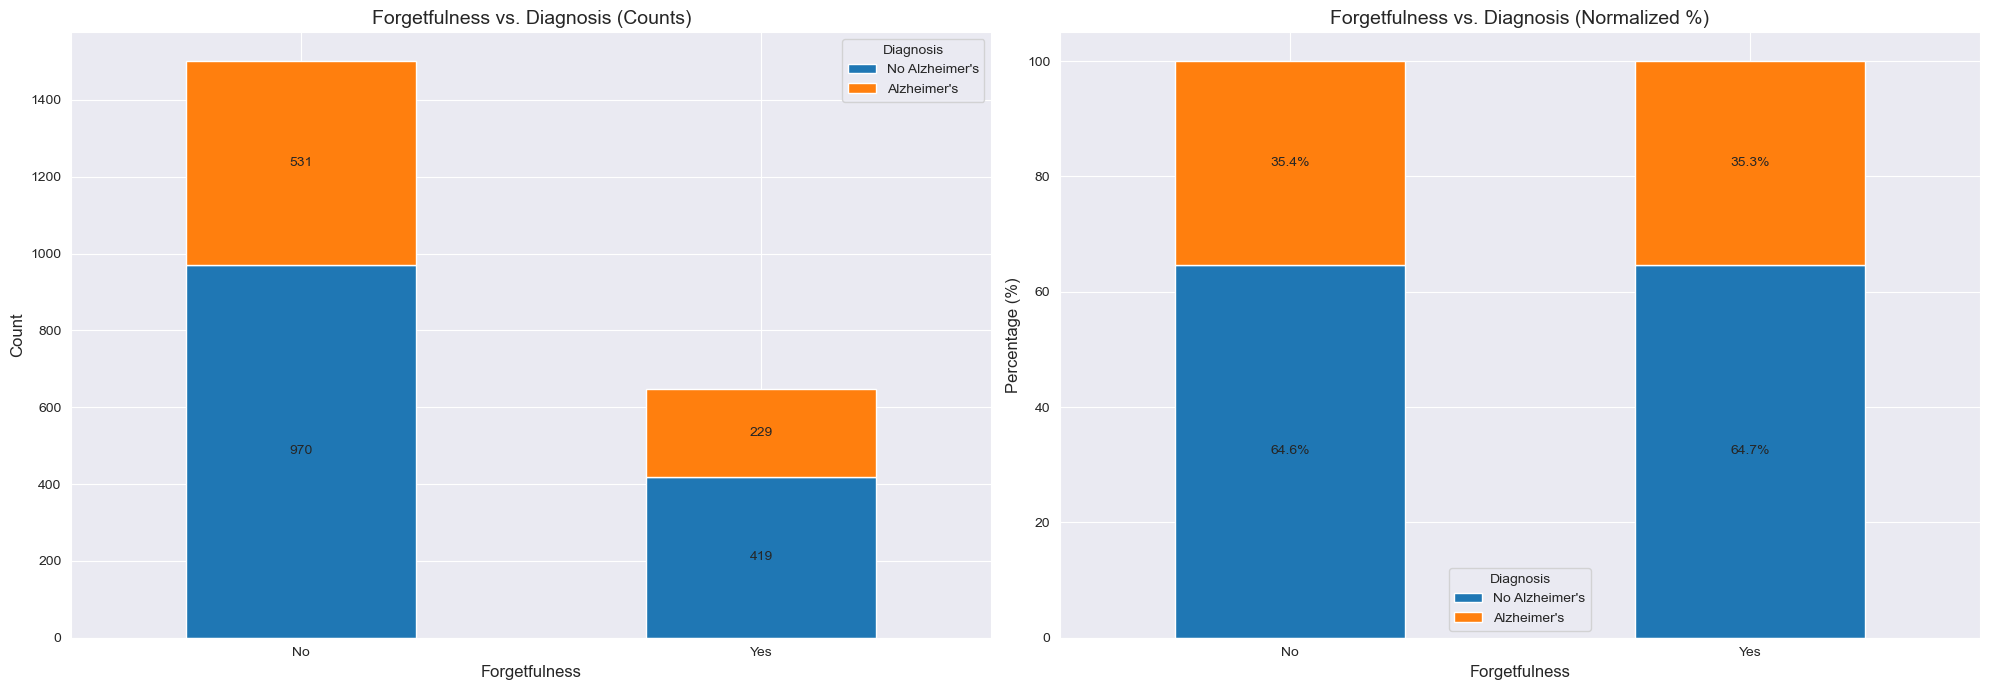

In [37]:
plot_categorical_crosstabs()

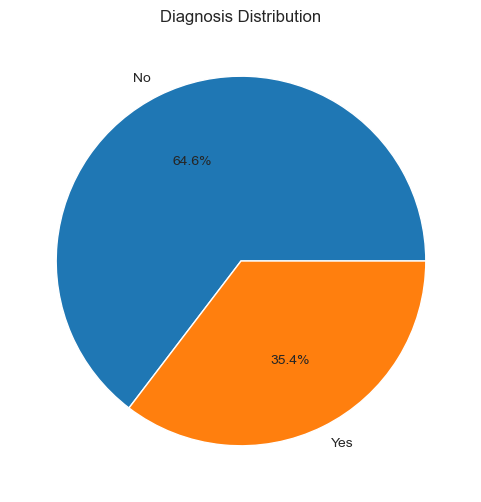

In [38]:
categories = ['No', 'Yes']
counts = dataset.Diagnosis.value_counts().tolist()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=categories, autopct='%1.1f%%')
plt.title('Diagnosis Distribution')
plt.show()

## A1: Data preprocessing and preparation

### Feature Scaling - Encoding

Perform one-hot encoding for nominal features with more than two categories, avoiding the dummy variable trap and multicollinearity.
Features of the dataset that fall into this category are:
- Ethnicity


Binary features will remain as they are.

In [39]:
def preprocess_data(X_train, X_val, features_to_encode, numerical_features=None):
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()

    # Process features that need one-hot encoding
    for feature in features_to_encode:
        # Init one-hot encoder
        one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

        # Fit and transform X_train and transform only X_val
        encoded_train = one_hot_encoder.fit_transform(X_train[[feature]])
        encoded_val = one_hot_encoder.transform(X_val[[feature]])

        # Generate new feature names
        feature_names = []
        categories = list(one_hot_encoder.categories_[0])
        for cat in categories[1:]:
            new_name = f"{feature}_{cat}"
            feature_names.append(new_name)

        # Create DataFrames with encoded data
        train_encoded_df = pd.DataFrame(encoded_train, columns=feature_names, index=X_train.index)
        val_encoded_df = pd.DataFrame(encoded_val, columns=feature_names, index=X_val.index)

        # Remove original feature and add encoded ones
        X_train_processed = X_train_processed.drop(columns=[feature])
        X_val_processed = X_val_processed.drop(columns=[feature])
        X_train_processed = pd.concat([X_train_processed, train_encoded_df], axis=1)
        X_val_processed = pd.concat([X_val_processed, val_encoded_df], axis=1)

    if numerical_features:
        mm_scaler = MinMaxScaler()
        X_train_processed[numerical_features] = mm_scaler.fit_transform(X_train_processed[numerical_features])
        X_val_processed[numerical_features] = mm_scaler.transform(X_val_processed[numerical_features])

    return X_train_processed, X_val_processed

In [44]:
X_train, x_val = preprocess_data(dataset.iloc[:2000], dataset.iloc[2000:], features_to_encode=['Ethnicity'], numerical_features=[
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'FunctionalAssessment'
])

In [45]:
X_train.head()

,PatientID,Age,Gender,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge,Ethnicity_1,Ethnicity_2,Ethnicity_3
0,4751,0.433333,0,2,0.316960,0,0.665183,0.633375,1.347214,9.025679,...,0,0,0,1,0,0,XXXConfid,0.0,0.0,0.0
1,4752,0.966667,0,0,0.473058,0,0.227170,0.762862,0.518767,7.151293,...,0,0,0,0,1,0,XXXConfid,0.0,0.0,0.0
2,4753,0.433333,0,1,0.111553,0,0.978276,0.785408,1.826335,9.673574,...,0,1,0,1,0,0,XXXConfid,0.0,0.0,1.0
3,4754,0.466667,1,1,0.752163,1,0.610751,0.843804,7.435604,8.392554,...,0,0,0,0,0,0,XXXConfid,0.0,0.0,0.0
4,4755,0.966667,0,0,0.228472,0,0.923204,0.631707,0.795498,5.597238,...,0,0,1,1,0,0,XXXConfid,0.0,0.0,0.0


In [46]:
x_val.head()

,PatientID,Age,Gender,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge,Ethnicity_1,Ethnicity_2,Ethnicity_3
2000,6751,1.000000,0,1,0.286294,0,0.574982,0.831499,2.303003,7.862230,...,0,1,0,0,1,1,XXXConfid,0.0,1.0,0.0
2001,6752,0.166667,0,1,0.623603,1,0.700625,0.017923,7.580054,4.312029,...,0,0,0,0,1,1,XXXConfid,1.0,0.0,0.0
2002,6753,0.133333,0,3,0.277182,0,0.419311,0.331159,9.468895,6.520243,...,0,0,0,1,0,1,XXXConfid,1.0,0.0,0.0
2003,6754,0.433333,0,0,0.192183,0,0.446997,0.877851,0.360870,4.527160,...,1,0,0,0,0,1,XXXConfid,0.0,0.0,0.0
2004,6755,0.400000,1,3,0.753373,1,0.613081,0.085286,5.458861,4.649400,...,0,0,0,0,0,1,XXXConfid,0.0,0.0,0.0


### 5-fold CV

In [42]:
target_column = 'Diagnosis'
features_to_encode = ['Ethnicity']
real_numerical_columns = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'FunctionalAssessment'
]

config = {
    'n_folds': 5,
    'batch_size': 1,
    'epochs': 10
}

def stratified_k_fold(dataset, target_column, config, features_to_encode, numerical_features=None):
    # Separate features from target
    X = dataset.drop(columns=[target_column])
    y = dataset[target_column]

    # Init stratified k-fold cross validation
    k_fold = StratifiedKFold(n_splits=config['n_folds'], shuffle=True, random_state=42)

    # Dict to store results
    results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'train_loss': [],
        'val_loss': []
    }

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        print(f"\n{'='*20} Fold {fold+1}/{config['n_folds']} {'='*20}")

        # Split into train and val sets
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Verify class distribution balance
        train_class_counts = y_train.value_counts().to_dict()
        val_class_counts = y_val.value_counts().to_dict()
        print(f"Training class distribution: {train_class_counts}")
        print(f"Validation class distribution: {val_class_counts}")

        # Apply preprocessing within the fold

        # Convert to PyTorch tensors

        # Create TensorDatasets

        # Create Dataloaders

        # Create Model instance

        # Train Model

        # Evaluate Model

        # Calculate Metrics

        # Store Results

        # Calculate and print final (average) results

In [43]:
stratified_k_fold(dataset, target_column, config, features_to_encode, numerical_features=real_numerical_columns)


==================== Fold 1/5 ====================
Training class distribution: {0: 1111, 1: 608}
Validation class distribution: {0: 278, 1: 152}

==================== Fold 2/5 ====================
Training class distribution: {0: 1111, 1: 608}
Validation class distribution: {0: 278, 1: 152}

==================== Fold 3/5 ====================
Training class distribution: {0: 1111, 1: 608}
Validation class distribution: {0: 278, 1: 152}

==================== Fold 4/5 ====================
Training class distribution: {0: 1111, 1: 608}
Validation class distribution: {0: 278, 1: 152}

==================== Fold 5/5 ====================
Training class distribution: {0: 1112, 1: 608}
Validation class distribution: {0: 277, 1: 152}
